## Initialization

In [2]:
# initialization

from ABCD import *
from tests import *

import matplotlib.pyplot as plt


GHz = 1e9
MHz = 1e6
kHz = 1e3
fF = 1e-15
um = 1e-6
us = 1e-6
ms = 1e-3
nH = 1e-9

pi = np.pi
vp = 1.2e8
z0 = 50

w_scale = 2*pi*MHz

plt.rcParams.update({
    'font.size'        : 12, 
    'figure.facecolor' : '1',
    'figure.dpi'       : 300,
    'figure.figsize'   : (5, 4),
})

<img src="images/readout_line.png" alt="readout_line" width="500">


## Some extra plots and equations

In [20]:
#estimaating the capcitance values for hanger readout with Purcell filter
import numpy as np
pi = np.pi

def hanger_vals(
    f_p, f_r,           # Hz
    kappa_p, J,         # rad/s
    Z0=50.0,            # ohms
    v_p=1.2e8,          # m/s (phase velocity)
    C_p_gr=0.0, C_g=0.0,# farads
    l_pr=0.0, l_rp=0.0  # meters
):
    """
    Implements:
      Cp = sqrt( (pi * kappa_p) / (4 * w_p^3 * Z0^2) )
      CJ = (pi * J) / ( 2 Z0 w_r w_p cos(pi/2 * l_pr/l_r) cos(pi/2 * l_rp/l_r) )
      lp = v_p/w_p * (pi/2 - Z0 w_p (Cp + C_p_gr))
      lr = v_p/w_r * (pi/2 - Z0 w_p C_g)     # uses ω_p in the last term per your sheet
    """
    w_p = 2*pi*f_p
    w_r = 2*pi*f_r

    # Eq. 1
    Cp = np.sqrt((pi * kappa_p) / (4.0 * (w_p**3) * (Z0**2)))

    # Eq. 4
    lr = v_p / w_r * (pi/2.0 - Z0 * w_p * C_g)

    # Eq. 3
    lp = v_p / w_p * (pi/2.0 - Z0 * w_p * (Cp + C_p_gr))

    # Eq. 2
    c1 = np.cos((pi/2.0) * (l_pr / lr))
    c2 = np.cos((pi/2.0) * (l_rp / lr))
    if np.isclose(c1, 0.0, atol=1e-12) or np.isclose(c2, 0.0, atol=1e-12):
        raise ValueError("cos() term in CJ denominator is ~0; adjust l_pr/l_r or l_rp/l_r.")
    CJ = (pi * J) / (2.0 * Z0 * w_r * w_p * c1 * c2)

    return {"Cp": Cp, "Cj": CJ, "lp": lp, "lr": lr, "wp": w_p, "wr": w_r}

# ---------- example (replace with your real numbers) ----------
GHz = 1e9; MHz = 1e6; fF = 1e-15; mm = 1e-3

vals = hanger_vals(
    f_p    = 7.38*GHz,          # probe / hanger freq
    f_r    = 7.38*GHz,          # resonator / readout freq
    kappa_p= 2*pi*150*MHz,      # linewidth (rad/s)
    J      = 2*pi*15*MHz,      # coupling rate (rad/s)
    Z0     = 50.0,
    v_p    = 1.2e8,             # phase velocity (m/s)
    C_p_gr = 35*fF,            # parasitic to ground
    C_g    = 49.0*fF,           # shunt to ground at readout
    l_pr   = 1.05*mm,            # geometric offsets
    l_rp   = (0.26 + .522 + .5/2 )*mm
)

# pretty print
for k, v in vals.items():
    if k in ("Cp","Cj"):
        print(f"{k} = {v*1e15:.3f} fF")
    elif k in ("lp","lr"):
        print(f"{k} = {v*1e3:.3f} mm")
    else:
        print(f"{k} = {v:.6e} rad/s")


Cp = 54.495 fF
Cj = 1.672 fF
lp = 3.528 mm
lr = 3.771 mm
wp = 4.636991e+10 rad/s
wr = 4.636991e+10 rad/s


In [83]:
3e8/np.sqrt(6.25)

np.float64(120000000.0)

## Kappa effective value calculation

In [84]:
import numpy as np

def kappa_split(Delta, kappa_p, J):
    """
    Compute (kappa1, kappa2) from
        kappa_{1,2} = kappa_p/2 ∓ Im sqrt( (Delta + i kappa_p/2)^2 + 4 J^2 )

    Args (all in rad/s):
        Delta   : detuning Δ = ω_r - ω_p  (scalar or NumPy array)
        kappa_p : Purcell-filter linewidth (external rate)
        J       : coupling rate

    Returns:
        k1, k2 (same shape as Delta), where by convention k1 <= k2.
    """
    z = (Delta + 1j * kappa_p / 2.0)**2 + 4.0 * J**2          # complex argument
    root = np.sqrt(z)                                         # principal branch
    k1 = kappa_p/2.0 - np.imag(root)
    k2 = kappa_p/2.0 + np.imag(root)
    return k1, k2


In [21]:
import numpy as np

def mode_split(omega_r, omega_p, kappa_p, J):
    """
    Compute (omega1, omega2, kappa1, kappa2) from the equations.
    By convention, omega1 <= omega2 and kappa1 <= kappa2.

    Args (all in rad/s):
        omega_r : readout resonator frequency
        omega_p : Purcell filter frequency
        kappa_p : Purcell-filter linewidth (external rate)
        J       : coupling rate

    Returns:
        omega1, omega2, kappa1, kappa2 (floats or arrays matching input shape).
    """
    Delta = omega_r - omega_p
    z = (Delta + 1j * kappa_p / 2.0)**2 + 4.0 * J**2          # complex argument
    root = np.sqrt(z)                                         # principal branch
    omega_mid = (omega_r + omega_p) / 2.0
    omega1 = omega_mid - 0.5 * np.real(root)
    omega2 = omega_mid + 0.5 * np.real(root)
    kappa1 = kappa_p / 2.0 - np.imag(root)
    kappa2 = kappa_p / 2.0 + np.imag(root)
    return omega1, omega2, kappa1, kappa2

In [699]:
import numpy as np

GHz = 1e9; MHz = 1e6; twopi = 2*np.pi

kappa_p = twopi * 150 * MHz  # 150 MHz (rad/s)
J = 0.075 * kappa_p            # at the exceptional point
omega_p = twopi * 7.35 * GHz    # example Purcell frequency (rad/s)
Delta = twopi * 0 * MHz     # Δ = 50 MHz (rad/s)
omega_r = omega_p + Delta    # readout frequency (rad/s)

omega1, omega2, kappa1, kappa2 = mode_split(omega_r, omega_p, kappa_p, J)
print(f"omega1: {omega1 / twopi / GHz:.3f} GHz, omega2: {omega2 / twopi / GHz:.3f} GHz")
print(f"kappa1: {kappa1 / twopi / MHz:.3f} MHz, kappa2: {kappa2 / twopi / MHz:.3f} MHz")

omega1: 7.350 GHz, omega2: 7.350 GHz
kappa1: 3.455 MHz, kappa2: 146.545 MHz


## Drawing a readout line

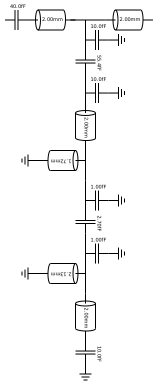

In [169]:
# drawing the shapes

lf = 4000*um # length of the feedline

C_1 = 40*fF
lf1 = 2000*um
lf2 = 2000*um

C_p =55.393*fF
C_p_gr = 10*fF
lp= 3717*um
lpr = 2000*um

lr = 4132*um
lrp = 2000*um
Cj = 2.699*fF
Cj_gr = 1*fF

Cg = 10*fF



w_arr = 2*pi* np.linspace(7.4, 7.8, 20_000) * GHz # frequency array in rad/s



abcd_readout_line = (
                            ABCDSeriesCapacitance(C_1)* 
                          ABCDTEMTransmissionLine(lf1,z0,vp)
                         * ABCDTJunction(ABCDInverse(ABCDTJunction(ABCDSeriesCapacitance(C_p_gr)))
                                         * ABCDSeriesCapacitance(C_p) 
                                         * ABCDInverse(ABCDTJunction(ABCDSeriesCapacitance(C_p_gr)))
                                         * ABCDTEMTransmissionLine(lpr,z0,vp) *  ABCDTJunction(ABCDTEMTransmissionLine(lp-lpr,z0,vp))
                                          *ABCDInverse(ABCDTJunction(ABCDSeriesCapacitance(Cj_gr)))
                                           * ABCDSeriesCapacitance(Cj)
                                           *ABCDInverse(ABCDTJunction(ABCDSeriesCapacitance(Cj_gr)))
                                           * ABCDTJunction(ABCDTEMTransmissionLine(lr-lrp,z0,vp))* ABCDTEMTransmissionLine(lrp,z0,vp)
                                            * ABCDSeriesCapacitance(Cg)
                                           ) 
                        *  ABCDTEMTransmissionLine(lf2,z0,vp))


abcd_readout_line

In [7]:
def plot_s21(
    w_arr: np.ndarray, # array of frequencies in rad/s, shape (N,)
    s21_tuple: list[Tuple[np.ndarray, str, str]], # tuple of s21 trace, label, and linestyle

    vline_list_1: List[float]=[], # list of values to plot as vlines, shape (M,1)
    v_line_list_2: List[float]=[], # list of values to plot as vlines, shape (M,1)
    label_1: str='', # label for the first vlines
    label_2: str='', # label for the second vlines

    ) -> None: # None
    
    #-- Calculate S21 in dB and plot -----------------------------------------------
    w_arr_ghz = w_arr / (2 * np.pi * GHz) # convert the x-axis to GHz

    for s21, label, linestyle in s21_tuple:
        plt.plot(
            w_arr_ghz,
            s21,
            linestyle=linestyle,
            label=label
        )
    

    #-- Add vertical lines if available --------------------------------
    for val in vline_list_1:
        plt.axvline(x=val, color='C1', linestyle='--')

    for val in v_line_list_2:
        plt.axvline(x=val, color='C2', linestyle='--')

    if label_1:
        plt.plot([], [], '--', color='C1', label=label_1)
    if label_2:
        plt.plot([], [], '--', color='C2', label=label_2)
    

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.xlabel('Frequency (GHz)')
    plt.ylabel('S21')
    plt.show()

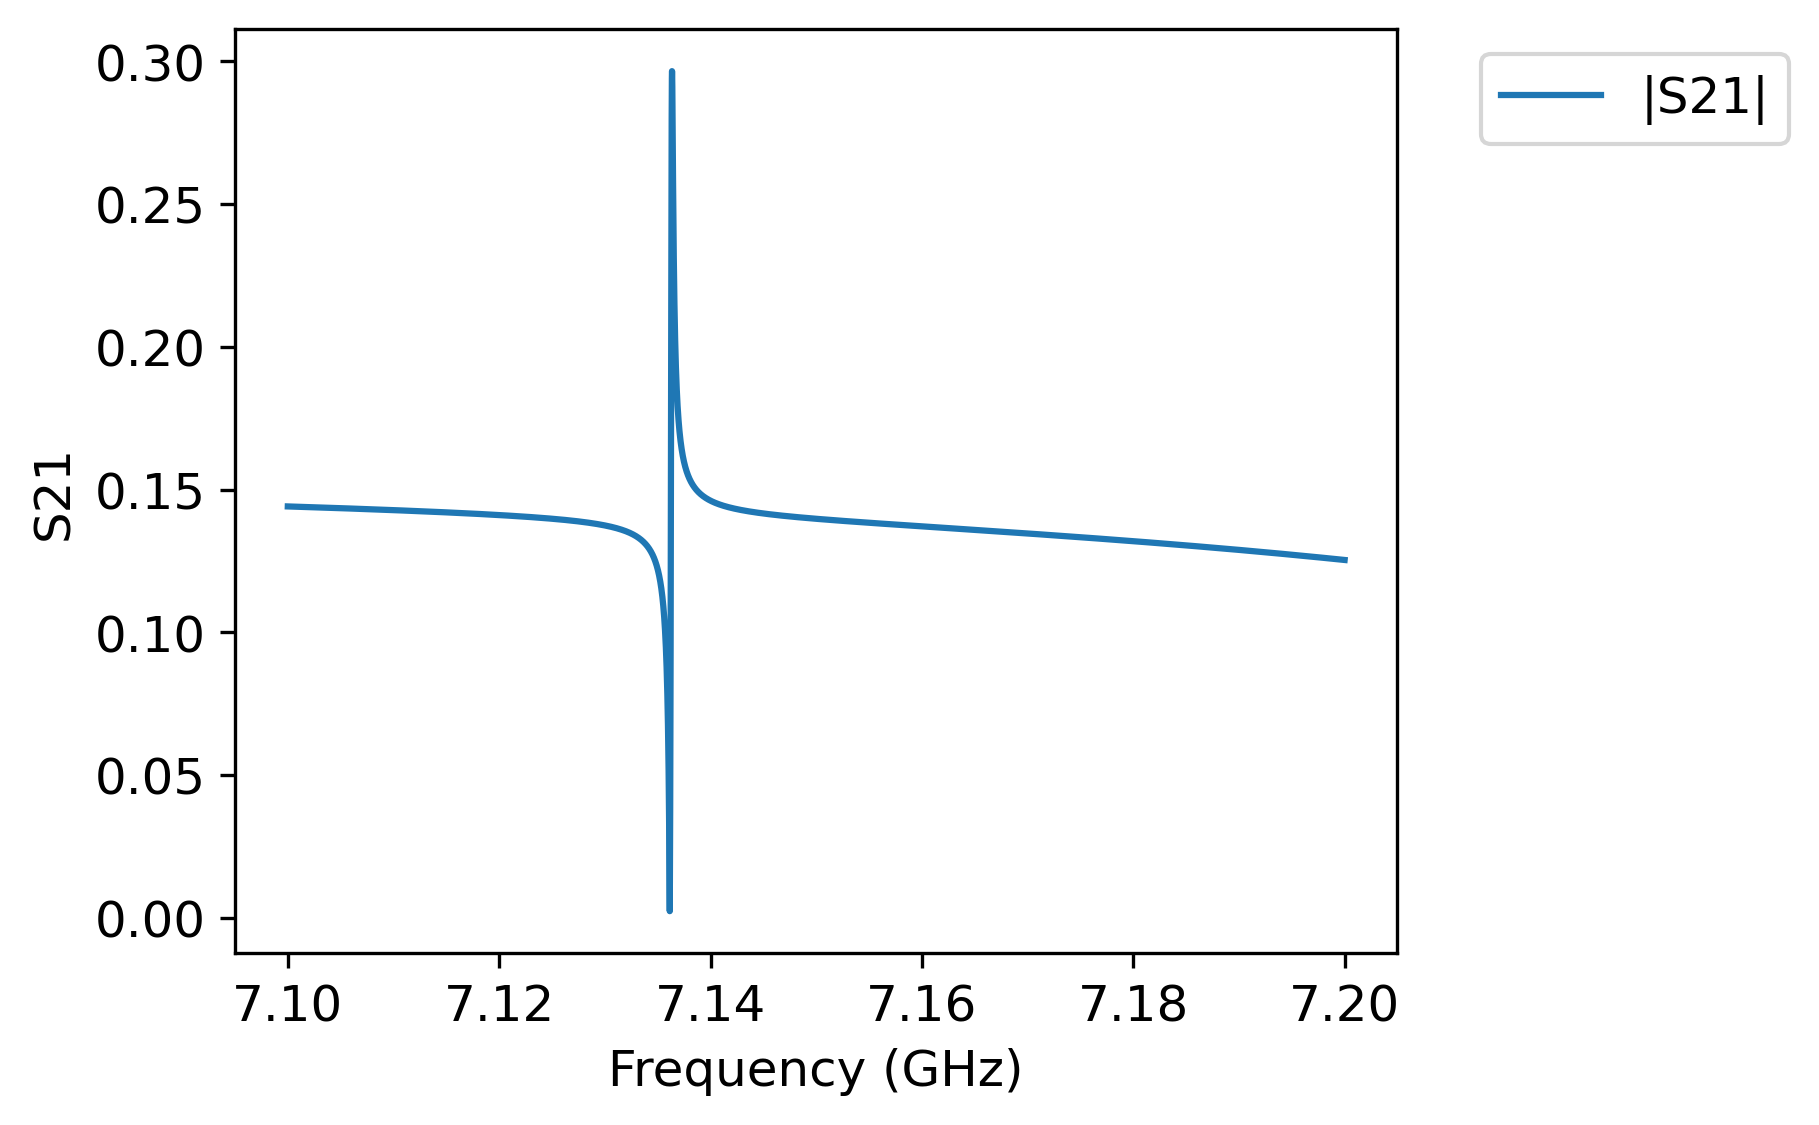

In [186]:
w_arr = 2*pi* np.linspace(7.1, 7.2, 10_000) * GHz # frequency array in rad/s
s21 = abcd_readout_line.sparams(w_arr, z0)[2]
plot_s21(
    w_arr,
    [(np.abs(s21), '|S21|', '-')]
)


In [190]:
fit_results_dict, s21_fit_trace = fit_resonance(w_arr, s21)

# wr and kr are in rad/s
wr = fit_results_dict['wr'] /2/pi/GHz # in GHz
kappa = fit_results_dict['kr'] /2/pi/MHz # in MHz

print(f'wr = {wr:.2f} GHz')
print(f'kappa = {kappa:.2f} MHz')

wr = 7.14 GHz
kappa = 0.18 MHz


In [188]:
from utils_2 import *
fit_results_dict, s21_fit_trace = fit_resonance_coupled(w_arr, s21)

# wr and kr are in rad/s
wr = fit_results_dict['omega_r'] /2/pi/GHz # in GHz
kappa = fit_results_dict['k'] /2/pi/MHz # in MHz

wp = fit_results_dict['omega_p'] /2/pi/GHz # in GHz
kp = fit_results_dict['kappa_p'] /2/pi/MHz # in MHz

print(f'wr = {wr:.2f} GHz')
print(f'kappa = {kappa:.2f} MHz')
print(f'wp = {wp:.2f} GHz')
print(f'kp = {kp:.2f} MHz')





wr = 7.14 GHz
kappa = -0.00 MHz
wp = 7.14 GHz
kp = 0.35 MHz


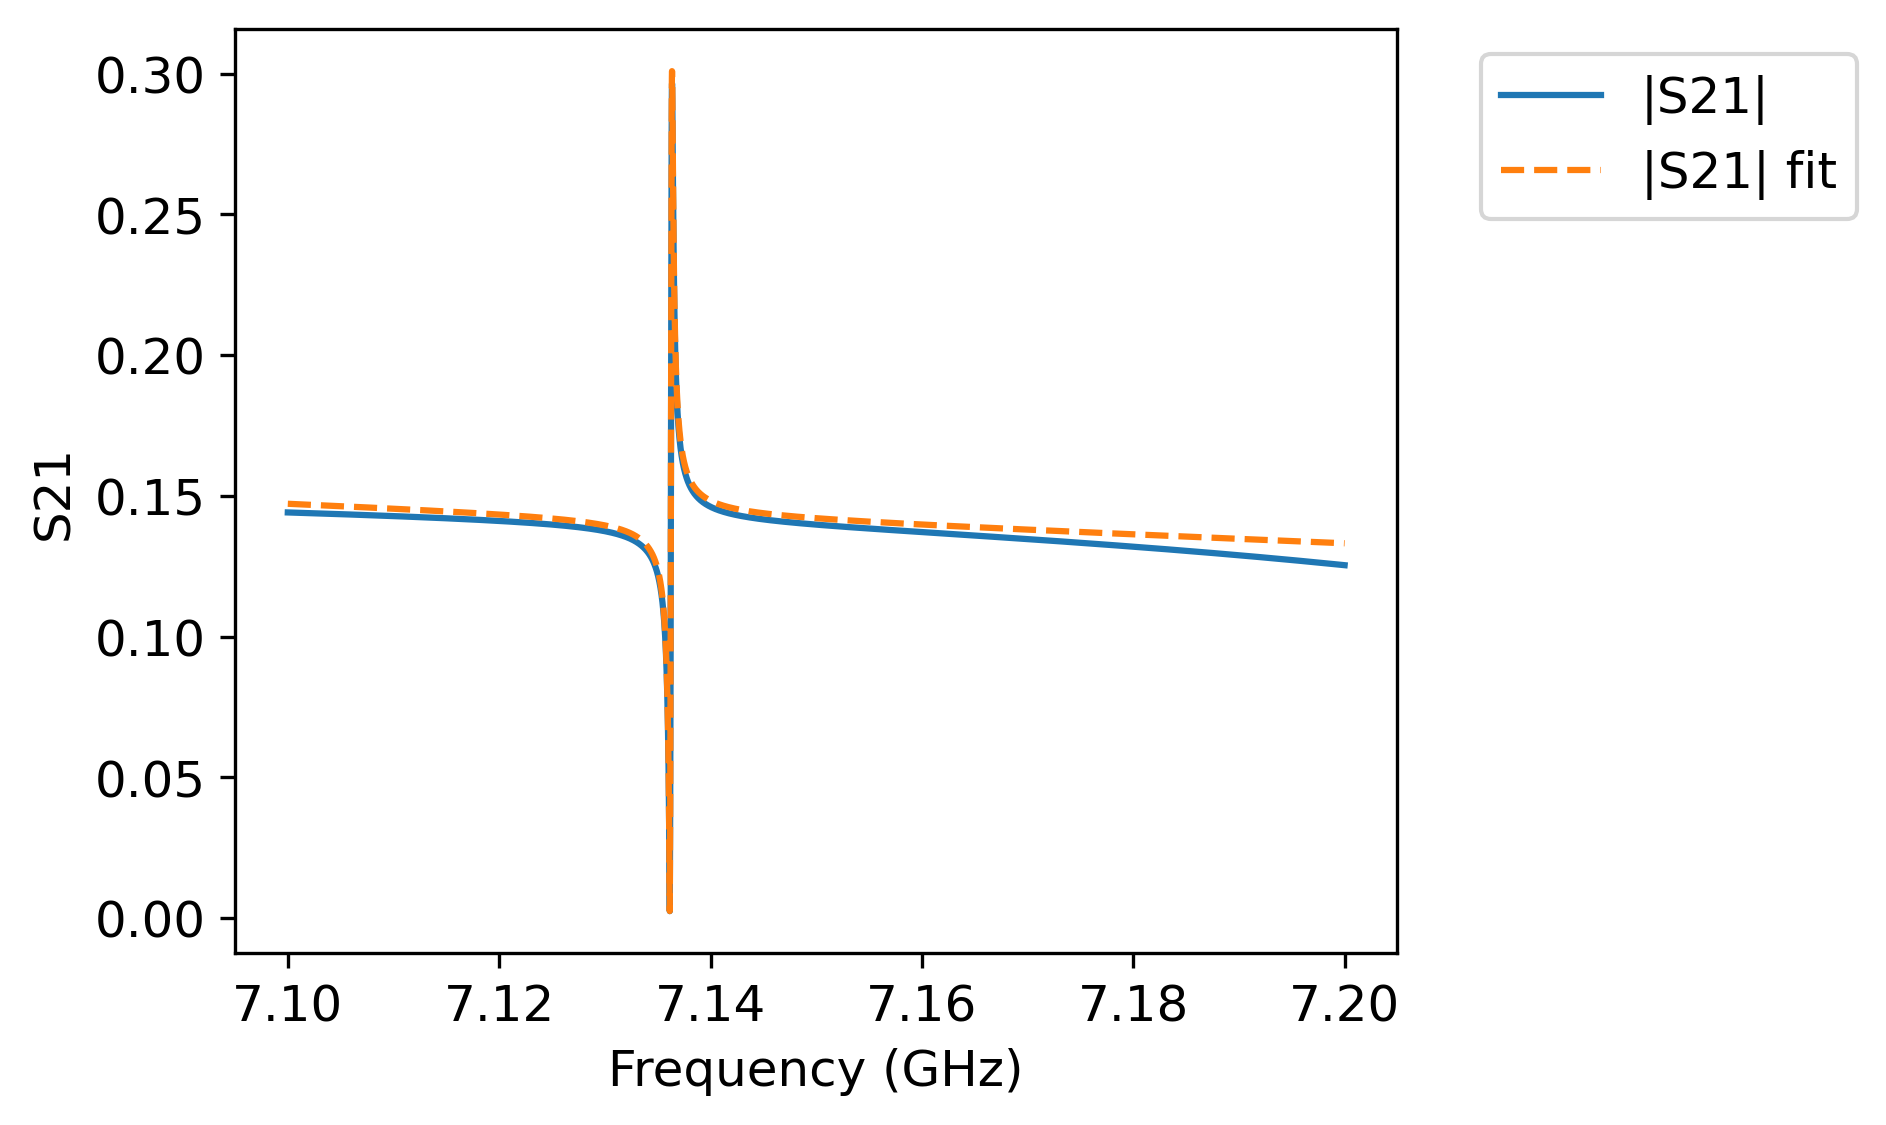

In [191]:
plot_s21(
    w_arr,
    [(np.abs(s21), '|S21|', '-'),
    (np.abs(s21_fit_trace), '|S21| fit', '--')]
)

## The Full Readout circuit for FUN14

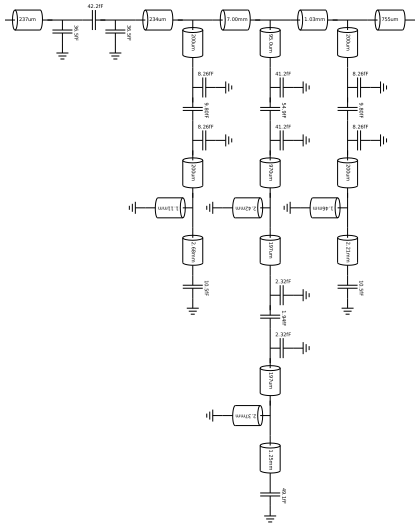

In [3]:
# drawing the shapes

lf = 15000*um # length of the feedline

#Start from left
lf_section_1 = 237*um
C_1 = 42.25*fF
C_1_gr = 36.5*fF

#Resonator for Q3
lf_section_2 = 234*um
Cc_Q3 = 9.8*fF
Cc_Q3_gr = 8.26*fF
lt_section_1 = (160+ 40)*um 
lt_section_2 = (160+ 40)*um

lrp_Q3 = (360+2300+25)*um
lr_Q3 = lrp_Q3 + (1090+25)*um

Cg_Q3 = 10.5*fF





# Reaout of Q2

lf_section_3 = 7000*um
lt_section_4  = 95*um
lt_section_5  = 197*um


C_p_Q2 =54.88*fF
C_p_gr_Q2 = 41.25*fF
lp_Q2= 3385*um
lpr_Q2 = .97*mm

lr_Q2 = 3625*um
lrp_Q2 = (0.27 + .73 + .5/2 )*mm
Cj_Q2 = 1.94*fF
Cj_gr_Q2 = 2.315*fF

Cg_Q2 = 49.1*fF
lf2 = 1028*um #lf-lf_section_3


#Resonator for Q1
lf_section_2 = 234*um
Cc_Q1 = 9.8*fF
Cc_Q1_gr = 8.26*fF
lt_section_6 = (160+ 40)*um # three fingers equivalent extra length so good approximation!? 
lt_section_7 = (160+ 40)*um

# lrp_Q1 = (370+1840+25)*um
lrp_Q1 = (360+1829+25)*um
lr_Q1 = lrp_Q1 + (1440+25)*um

Cg_Q1 = 10.5*fF
lf3 = 755*um


C_air_bridge = 1*fF





# w_arr = 2*pi* np.linspace(7.5, 7.7, 20_000) * GHz # frequency array in rad/s



abcd_readout_line_1 = (
                            ABCDTEMTransmissionLine(lf_section_1,z0,vp)
                            * ABCDTJunction(ABCDSeriesCapacitance(C_1_gr))
                            * ABCDSeriesCapacitance(C_1)
                            * ABCDTJunction(ABCDSeriesCapacitance(C_1_gr))
                          *ABCDTEMTransmissionLine(lf_section_2,z0,vp)
                          # *ABCDTEMTransmissionLine(lf1,z0,vp)
                         * ABCDTJunction(
                                          ABCDTEMTransmissionLine(lt_section_1,z0,vp)
                                          *ABCDInverse(ABCDTJunction(ABCDSeriesCapacitance(Cc_Q3_gr)))
                                           * ABCDSeriesCapacitance(Cc_Q3)
                                           *ABCDInverse(ABCDTJunction(ABCDSeriesCapacitance(Cc_Q3_gr)))
                                           *ABCDTEMTransmissionLine(lt_section_2,z0,vp)
                                           * ABCDTJunction(ABCDTEMTransmissionLine(lr_Q3-lrp_Q3,z0,vp))* ABCDTEMTransmissionLine(lrp_Q3,z0,vp)
                                            * ABCDSeriesCapacitance(Cg_Q3)
                                           ) 
                            *ABCDTEMTransmissionLine(lf_section_3,z0,vp)
                          * ABCDTJunction(
                                          ABCDTEMTransmissionLine(lt_section_4,z0,vp)
                                          *ABCDInverse(ABCDTJunction(ABCDSeriesCapacitance(C_p_gr_Q2)))
                                         * ABCDSeriesCapacitance(C_p_Q2) 
                                         * ABCDInverse(ABCDTJunction(ABCDSeriesCapacitance(C_p_gr_Q2)))
                                         * ABCDTEMTransmissionLine(lpr_Q2,z0,vp) *  ABCDTJunction(ABCDTEMTransmissionLine(lp_Q2-lpr_Q2,z0,vp))
                                         * ABCDTEMTransmissionLine(lt_section_5,z0,vp)
                                          *ABCDInverse(ABCDTJunction(ABCDSeriesCapacitance( Cj_gr_Q2)))
                                           * ABCDSeriesCapacitance(Cj_Q2)
                                           *ABCDInverse(ABCDTJunction(ABCDSeriesCapacitance(Cj_gr_Q2)))
                                           * ABCDTEMTransmissionLine(lt_section_5,z0,vp)
                                           * ABCDTJunction(ABCDTEMTransmissionLine(lr_Q2-lrp_Q2,z0,vp))* ABCDTEMTransmissionLine(lrp_Q2,z0,vp)
                                            * ABCDSeriesCapacitance(Cg_Q2)
                                           ) 
                        *  ABCDTEMTransmissionLine(lf2,z0,vp)
                          * ABCDTJunction(
                                          ABCDTEMTransmissionLine(lt_section_6,z0,vp)
                                          *ABCDInverse(ABCDTJunction(ABCDSeriesCapacitance(Cc_Q1_gr)))
                                           * ABCDSeriesCapacitance(Cc_Q1)
                                           *ABCDInverse(ABCDTJunction(ABCDSeriesCapacitance(Cc_Q1_gr)))
                                           *ABCDTEMTransmissionLine(lt_section_7,z0,vp)
                                           * ABCDTJunction(ABCDTEMTransmissionLine(lr_Q1-lrp_Q1,z0,vp))* ABCDTEMTransmissionLine(lrp_Q1,z0,vp)
                                            * ABCDSeriesCapacitance(Cg_Q1)
                                           ) 
                           *ABCDTEMTransmissionLine(lf3,z0,vp)
                        
                        
                        
                        
                        
                        
                        
                        )
                          


abcd_readout_line_1

In [4]:
def add_air_bridge(length, C_air_bridge, number_of_bridges, z0=None, vp=None):
    """
    Build a TEM line of total length with evenly spaced shunt capacitances
    to model air bridges.
    """
    if number_of_bridges <= 0:
        return ABCDTEMTransmissionLine(length, z0, vp)

    seg = length / (number_of_bridges + 1)

    net = ABCDTEMTransmissionLine(seg, z0, vp)
    for _ in range(number_of_bridges):
        net = (
            net
            * ABCDParallelCapacitance(C_air_bridge)
            * ABCDTEMTransmissionLine(seg, z0, vp)
        )
    return net


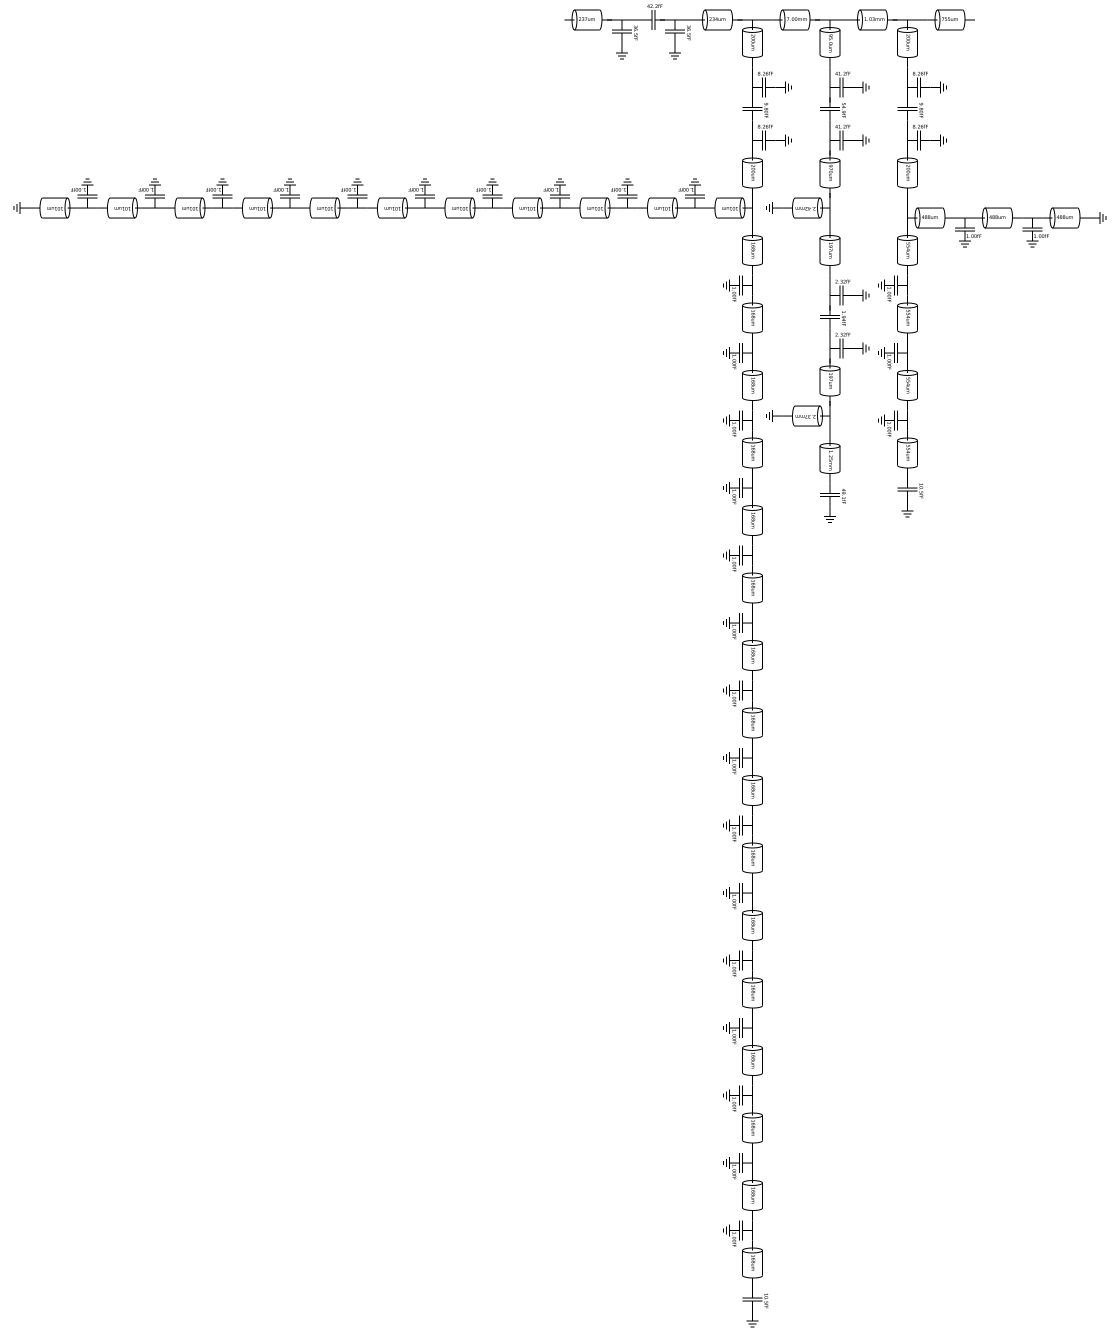

In [5]:
# considering air bridge capacitance of 1fF
# drawing the shapes

lf = 15000*um # length of the feedline

#Start from left
lf_section_1 = 237*um
C_1 = 42.25*fF
C_1_gr = 36.5*fF

#Resonator for Q3
lf_section_2 = 234*um
Cc_Q3 = 9.8*fF
Cc_Q3_gr = 8.26*fF
lt_section_1 = (160+ 40)*um 
lt_section_2 = (160+ 40)*um

lrp_Q3 = (360+2300+25)*um
lr_Q3 = lrp_Q3 + (1090+25)*um

lrp_Q3_1 = 200*um

Cg_Q3 = 10.5*fF





# Reaout of Q2

lf_section_3 = 7000*um
lt_section_4  = 95*um
lt_section_5  = 197*um


C_p_Q2 =54.88*fF
C_p_gr_Q2 = 41.25*fF
lp_Q2= 3385*um
lpr_Q2 = .97*mm

lr_Q2 = 3625*um
lrp_Q2 = (0.27 + .73 + .5/2 )*mm
Cj_Q2 = 1.94*fF
Cj_gr_Q2 = 2.315*fF

Cg_Q2 = 49.1*fF
lf2 = 1028*um #lf-lf_section_3


#Resonator for Q1
lf_section_2 = 234*um
Cc_Q1 = 9.8*fF
Cc_Q1_gr = 8.26*fF
lt_section_6 = (160+ 40)*um # three fingers equivalent extra length so good approximation!? 
lt_section_7 = (160+ 40)*um

# lrp_Q1 = (370+1840+25)*um
lrp_Q1 = (360+1829+25)*um




lr_Q1 = lrp_Q1 + (1440+25)*um

Cg_Q1 = 10.5*fF
lf3 = 755*um


C_air_bridge = 1*fF





# w_arr = 2*pi* np.linspace(7.5, 7.7, 20_000) * GHz # frequency array in rad/s


# def add_air_bridge(length, C_air_bridge, number_of_bridges):
#     # Function to add air bridge capacitance at regular intervals
#     #divide the length into ~number_of_bridges segments
#     #segment_length = length // number_of_bridges
#     # return ABCDTEMTransmissionLine(segment_length,z0,vp)* ABCDParallelCapacitance(C_air_bridge)*ABCDTEMTransmissionLine(2*segment_length,z0,vp)
#     # *ABCDParallelCapacitance(C_air_bridge)* ...ABCDTEMTransmissionLine(length - number_of_bridges*segment_length,z0,vp)
#   return 0

abcd_readout_line_1 = (
                            ABCDTEMTransmissionLine(lf_section_1,z0,vp)
                            * ABCDTJunction(ABCDSeriesCapacitance(C_1_gr))
                            * ABCDSeriesCapacitance(C_1)
                            * ABCDTJunction(ABCDSeriesCapacitance(C_1_gr))
                          *ABCDTEMTransmissionLine(lf_section_2,z0,vp)
                          # *ABCDTEMTransmissionLine(lf1,z0,vp)
                         * ABCDTJunction(
                                          ABCDTEMTransmissionLine(lt_section_1,z0,vp)
                                          *ABCDInverse(ABCDTJunction(ABCDSeriesCapacitance(Cc_Q3_gr)))
                                           * ABCDSeriesCapacitance(Cc_Q3)
                                           *ABCDInverse(ABCDTJunction(ABCDSeriesCapacitance(Cc_Q3_gr)))
                                           *ABCDTEMTransmissionLine(lt_section_2,z0,vp)

                                         
                                           * ABCDTJunction(
                                               
                                              #  ABCDTEMTransmissionLine(lr_Q3-lrp_Q3,z0,vp)
                                               add_air_bridge(lr_Q3-lrp_Q3, C_air_bridge, 10, z0=z0, vp=vp) 
                                               ) 
                                           
                                          #  * ABCDTEMTransmissionLine(lrp_Q3,z0,vp)
                                          * add_air_bridge(lrp_Q3, C_air_bridge, 15, z0=z0, vp=vp)

                                            * ABCDSeriesCapacitance(Cg_Q3)
                                           ) 
                            *ABCDTEMTransmissionLine(lf_section_3,z0,vp)
                          * ABCDTJunction(
                                          ABCDTEMTransmissionLine(lt_section_4,z0,vp)
                                          *ABCDInverse(ABCDTJunction(ABCDSeriesCapacitance(C_p_gr_Q2)))
                                         * ABCDSeriesCapacitance(C_p_Q2) 
                                         * ABCDInverse(ABCDTJunction(ABCDSeriesCapacitance(C_p_gr_Q2)))
                                         * ABCDTEMTransmissionLine(lpr_Q2,z0,vp) *  ABCDTJunction(ABCDTEMTransmissionLine(lp_Q2-lpr_Q2,z0,vp))
                                         * ABCDTEMTransmissionLine(lt_section_5,z0,vp)
                                          *ABCDInverse(ABCDTJunction(ABCDSeriesCapacitance( Cj_gr_Q2)))
                                           * ABCDSeriesCapacitance(Cj_Q2)
                                           *ABCDInverse(ABCDTJunction(ABCDSeriesCapacitance(Cj_gr_Q2)))
                                           * ABCDTEMTransmissionLine(lt_section_5,z0,vp)
                                           * ABCDTJunction(ABCDTEMTransmissionLine(lr_Q2-lrp_Q2,z0,vp))* ABCDTEMTransmissionLine(lrp_Q2,z0,vp)
                                            * ABCDSeriesCapacitance(Cg_Q2)
                                           ) 
                        *  ABCDTEMTransmissionLine(lf2,z0,vp)
                          * ABCDTJunction(
                                          ABCDTEMTransmissionLine(lt_section_6,z0,vp)
                                          *ABCDInverse(ABCDTJunction(ABCDSeriesCapacitance(Cc_Q1_gr)))
                                           * ABCDSeriesCapacitance(Cc_Q1)
                                           *ABCDInverse(ABCDTJunction(ABCDSeriesCapacitance(Cc_Q1_gr)))
                                           *ABCDTEMTransmissionLine(lt_section_7,z0,vp)
                                           * ABCDInverse(ABCDTJunction(
                                               
                                              #  ABCDTEMTransmissionLine(lr_Q1-lrp_Q1,z0,vp)
                                               add_air_bridge(lr_Q1-lrp_Q1, C_air_bridge, 2, z0=z0, vp=vp) 
                                               ))
                                           
                                          #  * ABCDTEMTransmissionLine(lrp_Q1,z0,vp)
                                          *add_air_bridge(lrp_Q1, C_air_bridge, 3, z0=z0, vp=vp) 
                                           
                                           
                                            * ABCDSeriesCapacitance(Cg_Q1)
                                           ) 
                           *ABCDTEMTransmissionLine(lf3,z0,vp)
                        
                        
                        
                        
                        
                        
                        
                        )
                          


abcd_readout_line_1

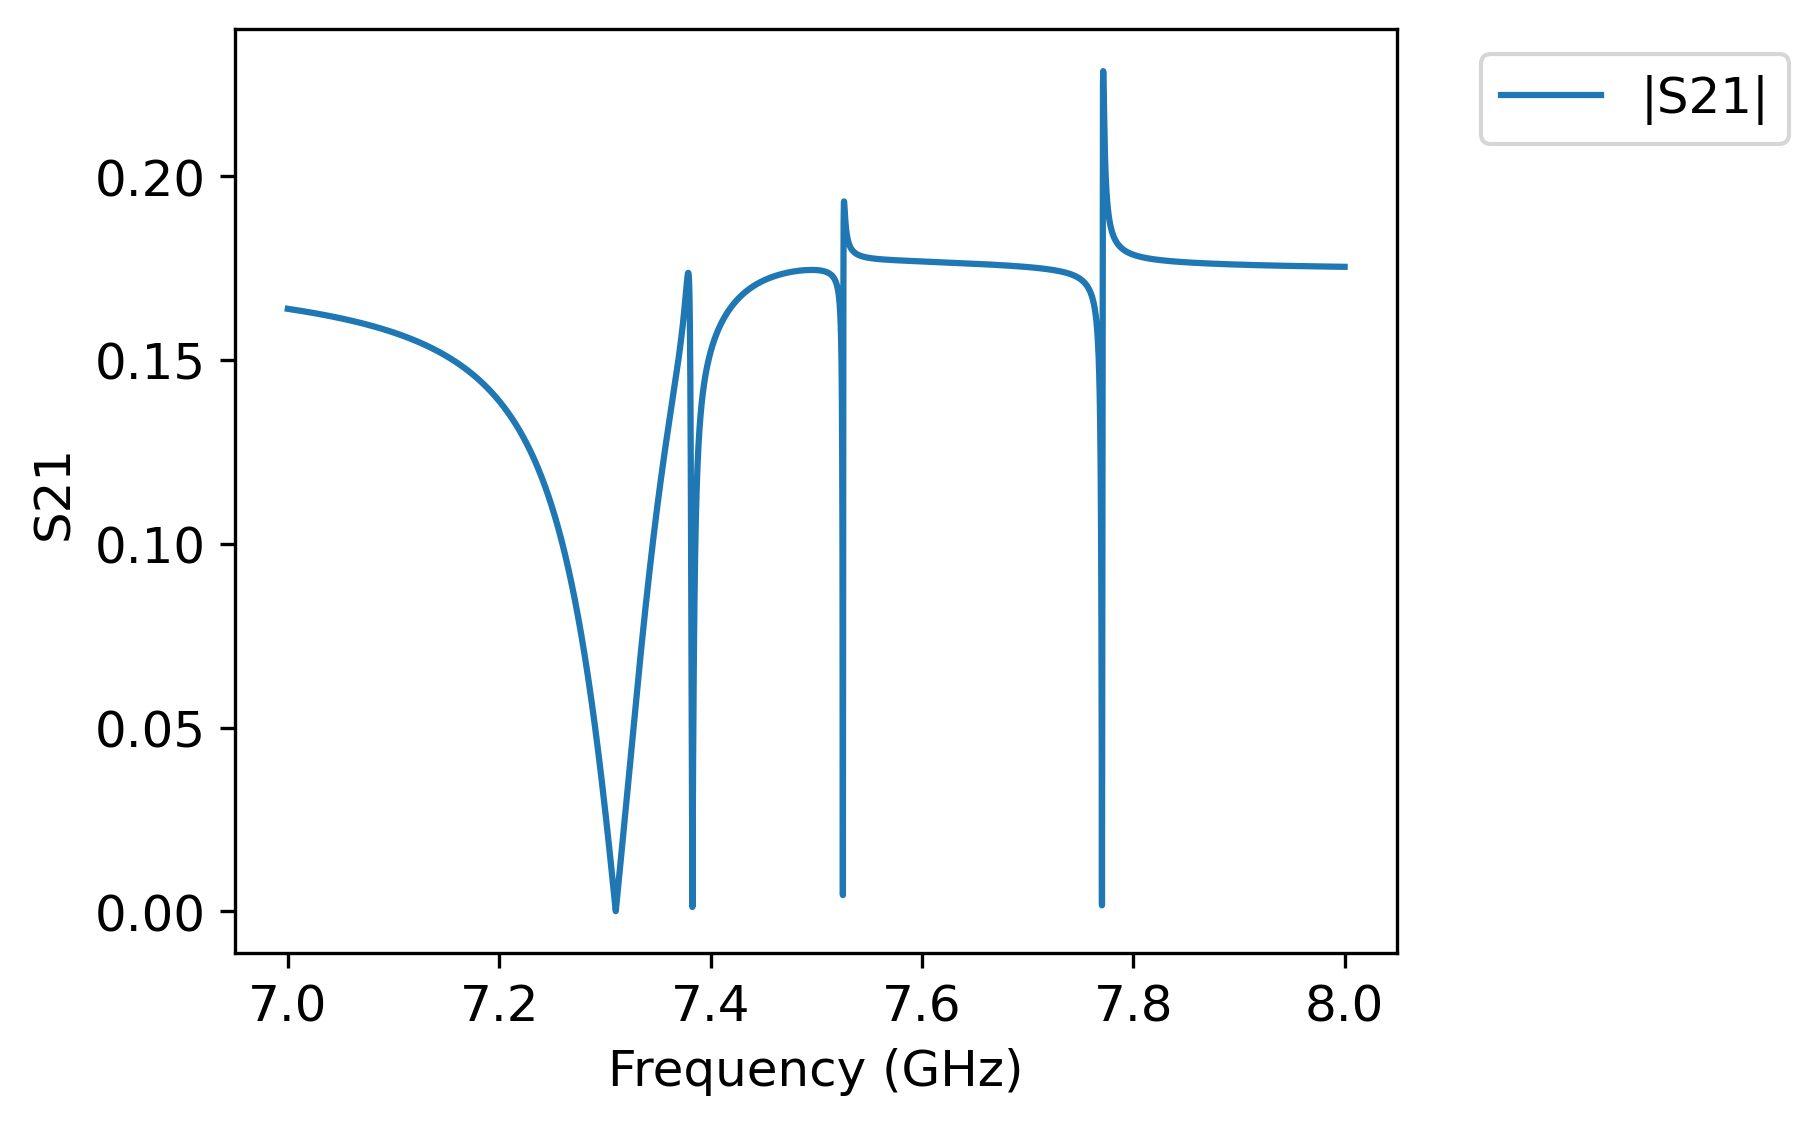

wr = 7.77 GHz
kappa = 1.15 MHz


/opt/homebrew/Caskroom/miniconda/base/envs/abcd_workshop/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


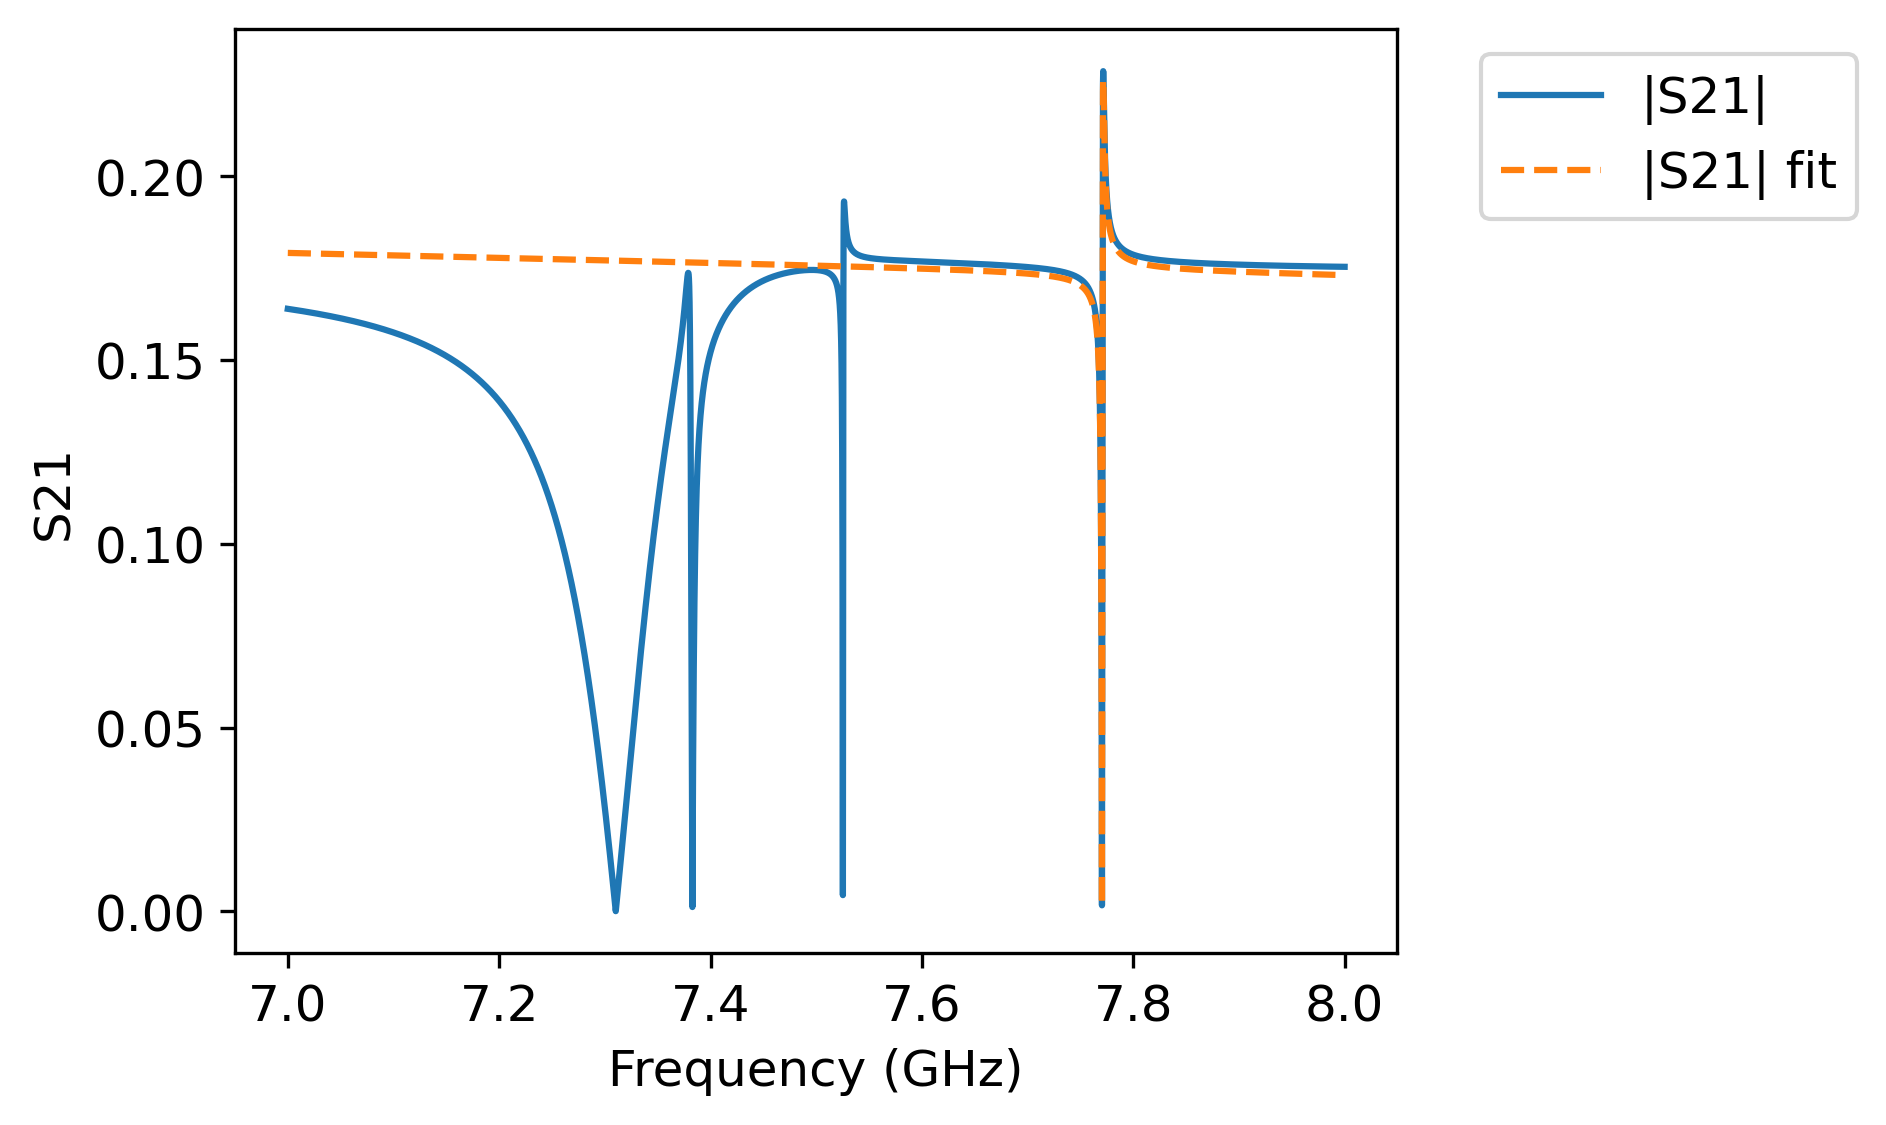

In [8]:
w_arr = 2*pi* np.linspace(7, 8, 30_000) * GHz # frequency array in rad/s
s21 = abcd_readout_line_1.sparams(w_arr, z0)[2]
plot_s21(
    w_arr,
    [(np.abs(s21), '|S21|', '-')]
)

fit_results_dict, s21_fit_trace = fit_resonance(w_arr, s21)
# wr and kr are in rad/s
wr = fit_results_dict['wr'] /2/pi/GHz # in GHz
kappa = fit_results_dict['kr'] /2/pi/MHz # in MHz

print(f'wr = {wr:.2f} GHz')
print(f'kappa = {kappa:.2f} MHz')

plot_s21(
    w_arr,
    [(np.abs(s21), '|S21|', '-'),
    (np.abs(s21_fit_trace), '|S21| fit', '--')]
)

In [317]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.close('all')          # clear any hidden/queued figures


### Fluxonium Cc calcualtion from kappa

In [379]:
import numpy as np

def calculate_Cc(kappa, Z0, omega_r):
    """
    Calculate Cc from the equation kappa = (2 Cc^2 Z0 omega_r^3) / pi.
    
    Args:
        kappa (float): Linewidth in rad/s.
        Z0 (float): Characteristic impedance in Ohms (e.g., 50).
        omega_r (float): Resonator frequency in rad/s.
    
    Returns:
        Cc (float): Capacitance in Farads.
    """
    return np.sqrt((kappa * np.pi) / (2 * Z0 * omega_r**3))

kappa = 2 * np.pi * 1e6  # 1.5 MHz in rad/s
Z0 = 50  # Ohms
omega_r = 2 * np.pi * 7.6e9  # 7.5 GHz in rad/s

Cc = calculate_Cc(kappa, Z0, omega_r)
print(f"Cc = {Cc * 1e15:.3f} fF")




import numpy as np

def calculate_k(C_c, omega_r, Z0, C_gr, l, v_p):
    """
    Calculate k from the equation:
    k = (C_c**2 * omega_r**2 * Z0**2) / (Z0 * (C_c + C_gr) * [1 + (omega_r * l / v_p) * Z0 * omega_r * (C_c + C_gr)] + l / v_p)
    
    Args:
        C_c (float): Coupling capacitance in Farads.
        omega_r (float): Resonator frequency in rad/s.
        Z0 (float): Characteristic impedance in Ohms.
        C_gr (float): Ground capacitance in Farads.
        l (float): Length in meters.
        v_p (float): Phase velocity in m/s.
    
    Returns:
        k (float): Linewidth in rad/s.
    """
    numer = C_c**2 * omega_r**2 * Z0**2
    bracket = 1 + (omega_r * l / v_p) * Z0 * omega_r * (C_c + C_gr)
    denom = Z0 * (C_c + C_gr) * bracket + l / v_p
    k = numer / denom
    return k




# Use case with sample values
C_c = 40*fF  # 20 fF
C_gr = 22*fF  # 1 fF
Z0 = 50  # Ohm
omega_r = 2 * np.pi * 7.35*GHz  # 7.6 GHz in rad/s
l = 3543*um  # 2000 um in m
v_p = 1.2e8  # m/s

k = calculate_k(C_c, omega_r, Z0, C_gr, l, v_p)
print(f"k = {k:.2e} rad/s")
print(f"k = {k / (2 * np.pi * 1e6):.2f} MHz")

Cc = 42.577 fF
k = 2.57e+08 rad/s
k = 40.86 MHz


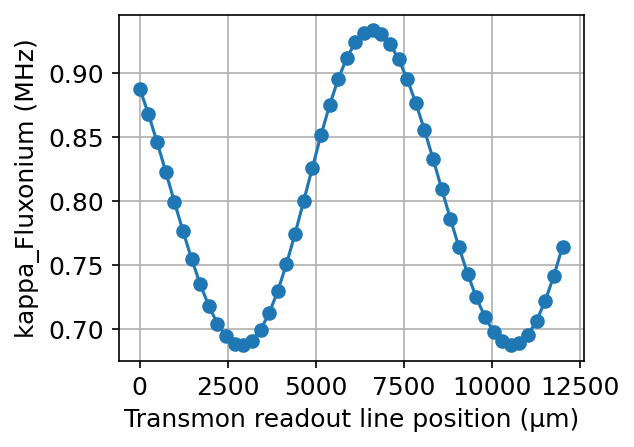

In [9]:
# Transmon readout line postion vary
import numpy as np
import matplotlib.pyplot as plt



#Start from left
lf_section_1 = 237*um
C_1 = 42.25*fF
C_1_gr = 36.5*fF

#Resonator for Q3
lf_section_2 = 234*um
Cc_Q3 = 9.8*fF
Cc_Q3_gr = 8.26*fF
lt_section_1 = (160+ 40)*um 
lt_section_2 = (160+ 40)*um

lrp_Q3 = (370+2300+25)*um
lr_Q3 = lrp_Q3 + (1090+25)*um

Cg_Q3 = 10.5*fF





# Reaout of Q2

lf_section_3 = 7000*um
lt_section_4  = 95*um
lt_section_5  = 197*um


C_p_Q2 =54.88*fF
C_p_gr_Q2 = 41.25*fF
lp_Q2= 3385*um
lpr_Q2 = .97*mm

lr_Q2 = 3625*um
lrp_Q2 = (0.27 + .73 + .5/2 )*mm
Cj_Q2 = 1.94*fF
Cj_gr_Q2 = 2.315*fF

Cg_Q2 = 49.1*fF
lf2 = 1028*um #lf-lf_section_3


#Resonator for Q1
lf_section_2 = 234*um
Cc_Q1 = 9.8*fF
Cc_Q1_gr = 8.26*fF
lt_section_6 = (160+ 40)*um # three fingers equivalent extra length so good approximation!? 
lt_section_7 = (160+ 40)*um

# lrp_Q1 = (370+1840+25)*um
lrp_Q1 = (360+1829+25)*um
lr_Q1 = lrp_Q1 + (1440+25)*um


Cg_Q1 = 10.5*fF
lf3 = 755*um
w_arr = 2*pi* np.linspace(7.7, 7.9, 30_000) * GHz # frequency array in rad/s


# Total length to keep constant
L_total = 12000*um#lf_section_3 + lf2

# Sweep range for lf_section_3 (0 to L_total)
n_points = 50
lf3_vals = np.linspace(0, L_total, n_points)

kappa_vals = []

for lf_section_3_val in lf3_vals:
    lf2_val = L_total - lf_section_3_val

    # Rebuild ABCD circuit with updated lf_section_3 and lf2
    abcd_readout_line = (
        ABCDTEMTransmissionLine(lf_section_1, z0, vp)
        * ABCDTJunction(ABCDSeriesCapacitance(C_1_gr))
        * ABCDSeriesCapacitance(C_1)
        * ABCDTJunction(ABCDSeriesCapacitance(C_1_gr))
        * ABCDTEMTransmissionLine(lf_section_2, z0, vp)
        * ABCDTJunction(
            ABCDTEMTransmissionLine(lt_section_1, z0, vp)
            * ABCDInverse(ABCDTJunction(ABCDSeriesCapacitance(Cc_Q3_gr)))
            * ABCDSeriesCapacitance(Cc_Q3)
            * ABCDInverse(ABCDTJunction(ABCDSeriesCapacitance(Cc_Q3_gr)))
            * ABCDTEMTransmissionLine(lt_section_2, z0, vp)
            * ABCDTJunction(ABCDTEMTransmissionLine(lr_Q3 - lrp_Q3, z0, vp))
            * ABCDTEMTransmissionLine(lrp_Q3, z0, vp)
            * ABCDSeriesCapacitance(Cg_Q3)
        )
        * ABCDTEMTransmissionLine(lf_section_3_val, z0, vp)
        * ABCDTJunction(
            ABCDTEMTransmissionLine(lt_section_4, z0, vp)
            * ABCDInverse(ABCDTJunction(ABCDSeriesCapacitance(C_p_gr_Q2)))
            * ABCDSeriesCapacitance(C_p_Q2)
            * ABCDInverse(ABCDTJunction(ABCDSeriesCapacitance(C_p_gr_Q2)))
            * ABCDTEMTransmissionLine(lpr_Q2, z0, vp)
            * ABCDTJunction(ABCDTEMTransmissionLine(lp_Q2 - lpr_Q2, z0, vp))
            * ABCDTEMTransmissionLine(lt_section_5, z0, vp)
            * ABCDInverse(ABCDTJunction(ABCDSeriesCapacitance(Cj_gr_Q2)))
            * ABCDSeriesCapacitance(Cj_Q2)
            * ABCDInverse(ABCDTJunction(ABCDSeriesCapacitance(Cj_gr_Q2)))
            * ABCDTEMTransmissionLine(lt_section_5, z0, vp)
            * ABCDTJunction(ABCDTEMTransmissionLine(lr_Q2 - lrp_Q2, z0, vp))
            * ABCDTEMTransmissionLine(lrp_Q2, z0, vp)
            * ABCDSeriesCapacitance(Cg_Q2)
        )
        * ABCDTEMTransmissionLine(lf2_val, z0, vp)
        * ABCDTJunction(
            ABCDTEMTransmissionLine(lt_section_6, z0, vp)
            * ABCDInverse(ABCDTJunction(ABCDSeriesCapacitance(Cc_Q1_gr)))
            * ABCDSeriesCapacitance(Cc_Q1)
            * ABCDInverse(ABCDTJunction(ABCDSeriesCapacitance(Cc_Q1_gr)))
            * ABCDTEMTransmissionLine(lt_section_7, z0, vp)
            * ABCDTJunction(ABCDTEMTransmissionLine(lr_Q1 - lrp_Q1, z0, vp))
            * ABCDTEMTransmissionLine(lrp_Q1, z0, vp)
            * ABCDSeriesCapacitance(Cg_Q1)
        )
        * ABCDTEMTransmissionLine(lf3, z0, vp)
    )

    # Compute S21
    s21 = abcd_readout_line.sparams(w_arr, z0)[2]

    # Fit resonance
    fit_results_dict, s21_fit_trace = fit_resonance(w_arr, s21)
    kappa = fit_results_dict['kr'] / (2 * np.pi * MHz)
    kappa_vals.append(kappa)

# --- Plot ---
plt.figure(figsize =(4, 3), dpi=150)
plt.plot(lf3_vals/um, kappa_vals, 'o-')
plt.xlabel("Transmon readout line position (µm)")
plt.ylabel("kappa_Fluxonium (MHz)")

plt.grid(True)
plt.show()


In [ ]:
## After Feedback.



## Trying to make both filter and resnator on resonance and Final version

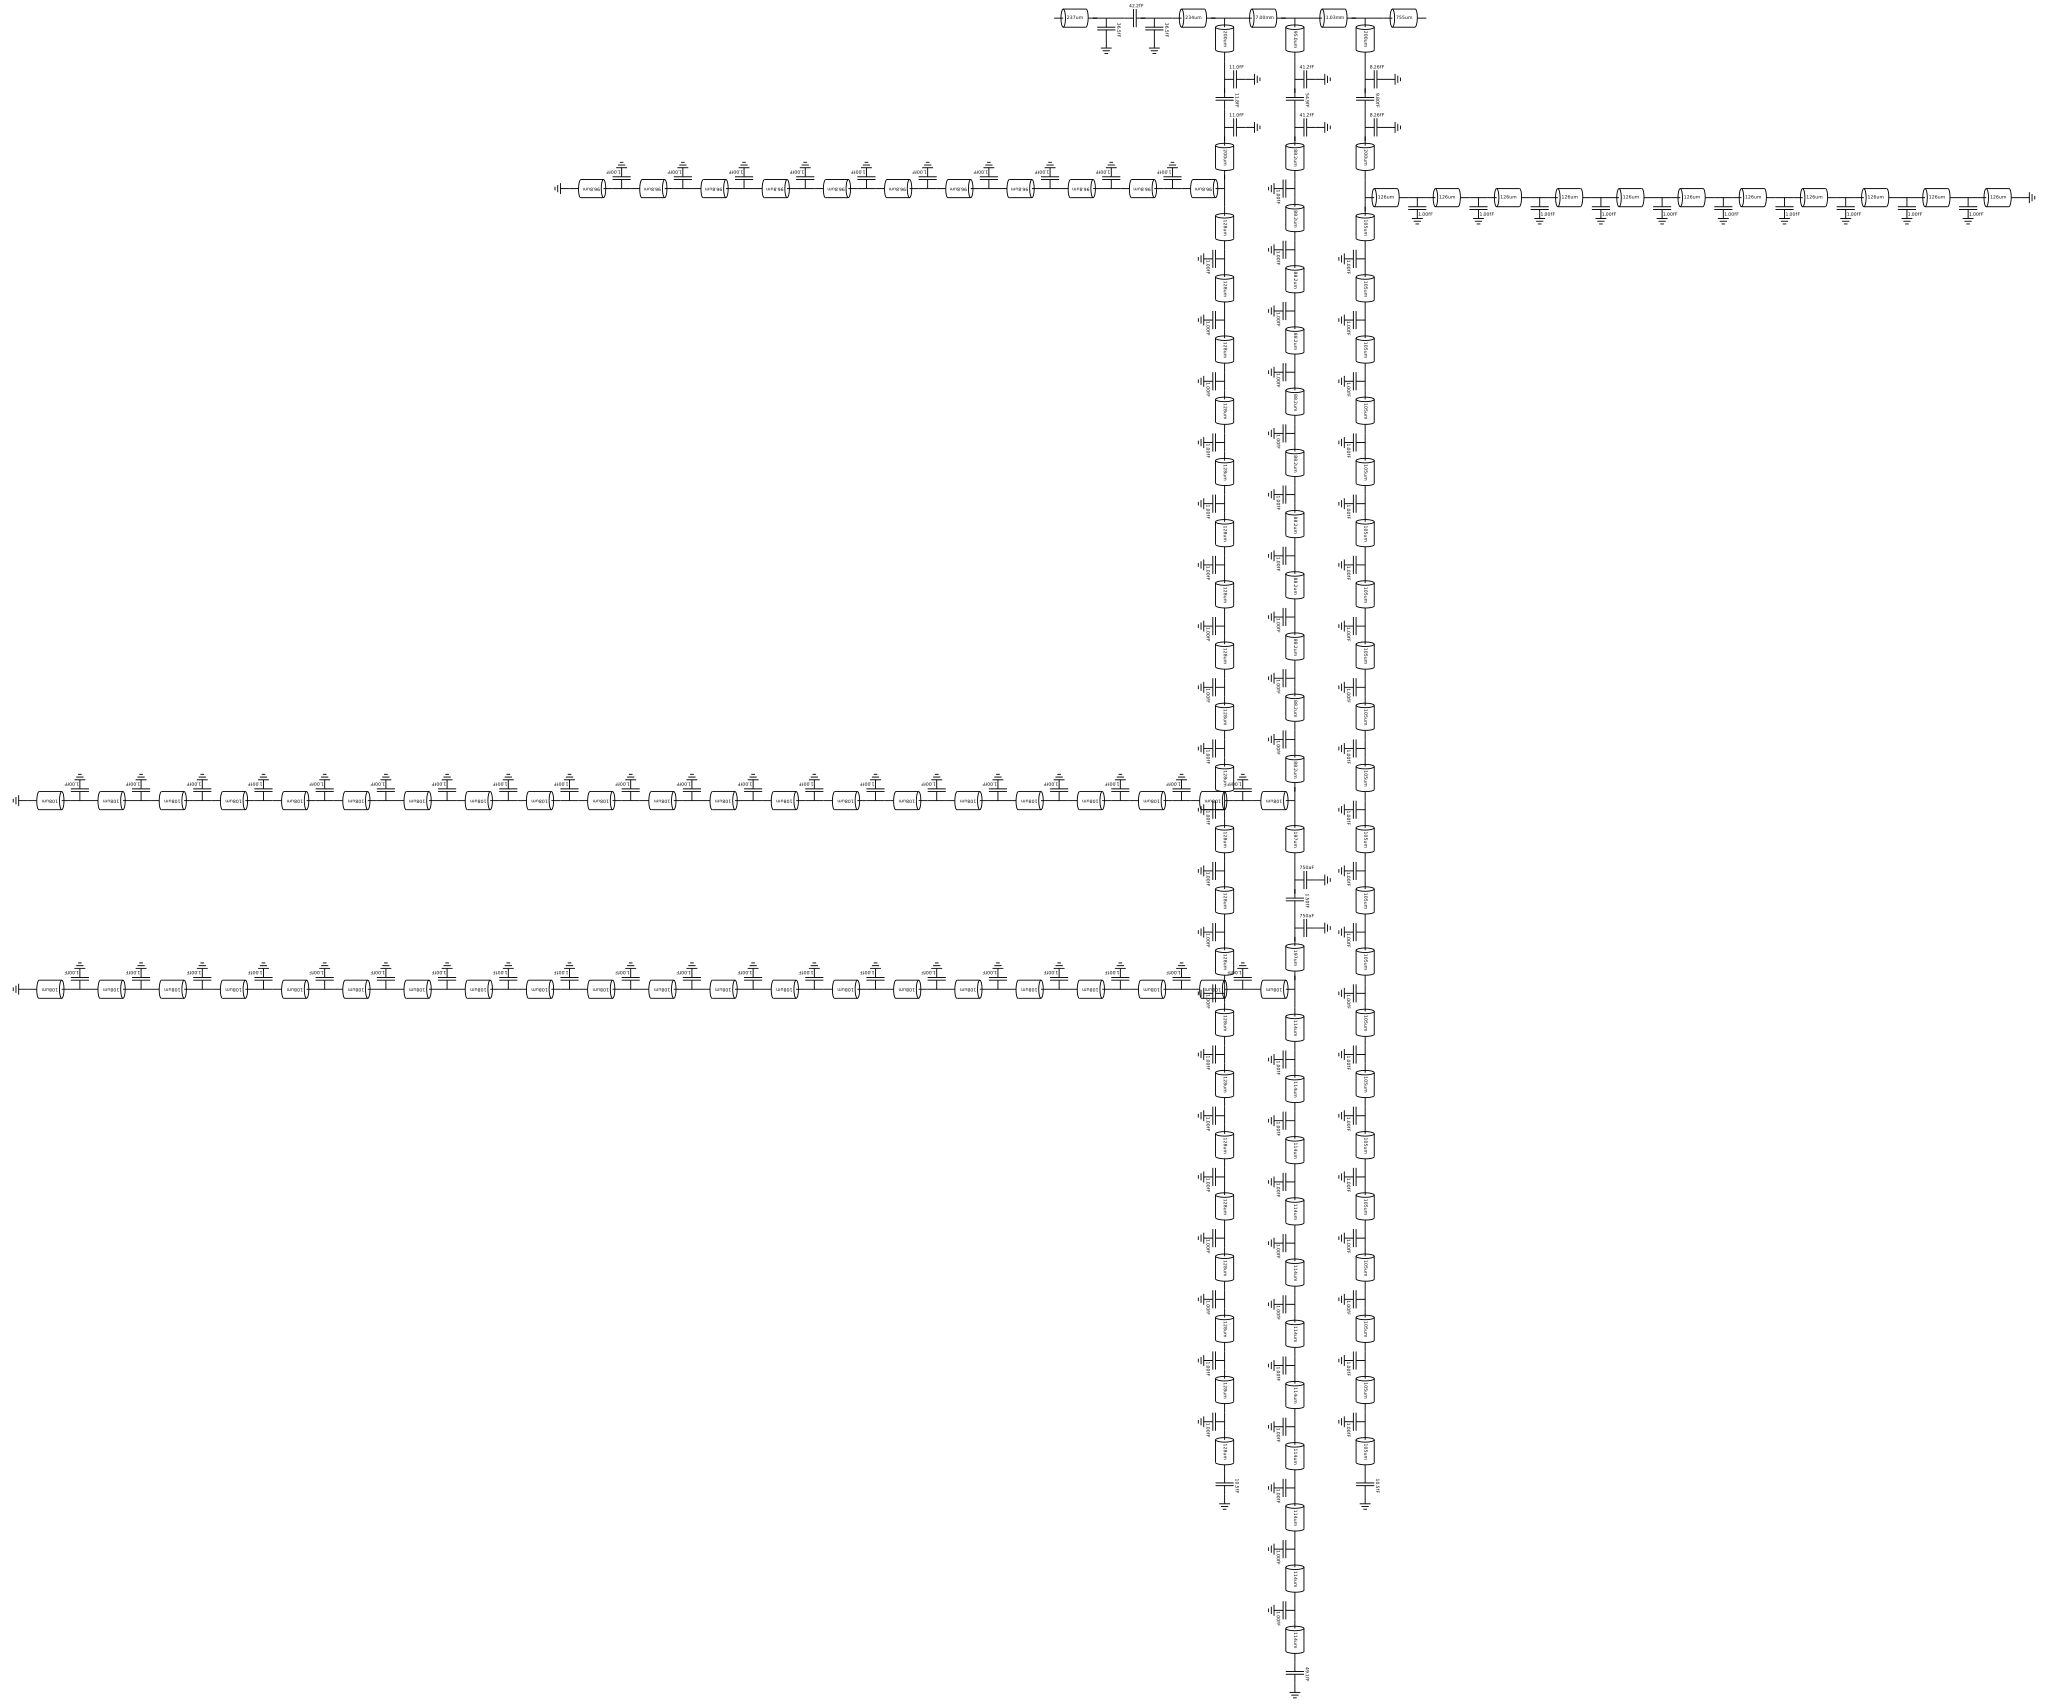

In [145]:
# considering air bridge capacitance of 1fF
# drawing the shapes

lf = 15000*um # length of the feedline

#Start from left
lf_section_1 = 237*um
C_1 = 42.25*fF
C_1_gr = 36.5*fF

#Resonator for Q3
lf_section_2 = 234*um
Cc_Q3 = 11.79*fF #9.8*fF
Cc_Q3_gr = 11.007*fF  # 8.26*fF
lt_section_1 = (160+ 40)*um # consider the length in the coupler part too. total coupler 400um so divided by two. 
lt_section_2 = (160+ 40)*um

lrp_Q3 = (360+2312+25)*um
lr_Q3 = lrp_Q3 + (1040+25)*um

lrp_Q3_1 = 200*um

Cg_Q3 = 10.5*fF





# Reaout of Q2

lf_section_3 = 7000*um
lt_section_4  = 95*um
lt_section_5  = 197*um


C_p_Q2 =54.88*fF
C_p_gr_Q2 = 41.25*fF
lp_Q2= 3238*um
lpr_Q2 = .97*mm

lr_Q2 = 3515*um
lrp_Q2 = (0.27 + .73 + .5/2 )*mm
Cj_Q2 = 1.5*fF
Cj_gr_Q2 = 0.75*fF

Cg_Q2 = 49.1*fF
lf2 = 1028*um #lf-lf_section_3


#Resonator for Q1
lf_section_2 = 234*um
Cc_Q1 = 9.8*fF
Cc_Q1_gr = 8.26*fF
lt_section_6 = (160+ 40)*um # three fingers equivalent extra length so good approximation!? 
lt_section_7 = (160+ 40)*um

# lrp_Q1 = (370+1840+25)*um
lrp_Q1 = (360+1829+25)*um




lr_Q1 = lrp_Q1 + (1360+25)*um #check when updated this

Cg_Q1 = 10.5*fF
lf3 = 755*um


C_air_bridge = 1*fF





# w_arr = 2*pi* np.linspace(7.5, 7.7, 20_000) * GHz # frequency array in rad/s


# def add_air_bridge(length, C_air_bridge, number_of_bridges):
#     # Function to add air bridge capacitance at regular intervals
#     #divide the length into ~number_of_bridges segments
#     #segment_length = length // number_of_bridges
#     # return ABCDTEMTransmissionLine(segment_length,z0,vp)* ABCDParallelCapacitance(C_air_bridge)*ABCDTEMTransmissionLine(2*segment_length,z0,vp)
#     # *ABCDParallelCapacitance(C_air_bridge)* ...ABCDTEMTransmissionLine(length - number_of_bridges*segment_length,z0,vp)
#   return 0

abcd_readout_line_1 = (
                            ABCDTEMTransmissionLine(lf_section_1,z0,vp)
                            * ABCDTJunction(ABCDSeriesCapacitance(C_1_gr))
                            * ABCDSeriesCapacitance(C_1)
                            * ABCDTJunction(ABCDSeriesCapacitance(C_1_gr))
                          *ABCDTEMTransmissionLine(lf_section_2,z0,vp)
                          # *ABCDTEMTransmissionLine(lf1,z0,vp)
                         * ABCDTJunction(
                                          ABCDTEMTransmissionLine(lt_section_1,z0,vp)
                                          *ABCDInverse(ABCDTJunction(ABCDSeriesCapacitance(Cc_Q3_gr)))
                                           * ABCDSeriesCapacitance(Cc_Q3)
                                           *ABCDInverse(ABCDTJunction(ABCDSeriesCapacitance(Cc_Q3_gr)))
                                           *ABCDTEMTransmissionLine(lt_section_2,z0,vp)

                                         
                                           * ABCDTJunction(
                                               
                                              #  ABCDTEMTransmissionLine(lr_Q3-lrp_Q3,z0,vp)
                                               add_air_bridge(lr_Q3-lrp_Q3, C_air_bridge, 10, z0=z0, vp=vp) 
                                               ) 
                                           
                                          #  * ABCDTEMTransmissionLine(lrp_Q3,z0,vp)
                                          * add_air_bridge(lrp_Q3, C_air_bridge, 20, z0=z0, vp=vp)

                                            * ABCDSeriesCapacitance(Cg_Q3)
                                           ) 
                            *ABCDTEMTransmissionLine(lf_section_3,z0,vp)
                          * ABCDTJunction(
                                          ABCDTEMTransmissionLine(lt_section_4,z0,vp)
                                          *ABCDInverse(ABCDTJunction(ABCDSeriesCapacitance(C_p_gr_Q2)))
                                         * ABCDSeriesCapacitance(C_p_Q2) 
                                         * ABCDInverse(ABCDTJunction(ABCDSeriesCapacitance(C_p_gr_Q2)))


                                        #  * ABCDTEMTransmissionLine(lpr_Q2,z0,vp) 
                                         * add_air_bridge(lpr_Q2, C_air_bridge, 10, z0=z0, vp=vp)
                                         
                                         *  ABCDTJunction(
                                            #  ABCDTEMTransmissionLine(lp_Q2-lpr_Q2,z0,vp)
                                             add_air_bridge(lp_Q2-lpr_Q2, C_air_bridge, 20, z0=z0, vp=vp)
                                                              
                                                              )
                                         
                                         
                                         * ABCDTEMTransmissionLine(lt_section_5,z0,vp)
                                          *ABCDInverse(ABCDTJunction(ABCDSeriesCapacitance( Cj_gr_Q2)))
                                           * ABCDSeriesCapacitance(Cj_Q2)
                                           *ABCDInverse(ABCDTJunction(ABCDSeriesCapacitance(Cj_gr_Q2)))
                                           * ABCDTEMTransmissionLine(lt_section_5,z0,vp)

                                           * ABCDTJunction(
                                              #  ABCDTEMTransmissionLine(lr_Q2-lrp_Q2,z0,vp)
                                               add_air_bridge(lr_Q2-lrp_Q2, C_air_bridge, 20, z0=z0, vp=vp)
                                               )
                                           
                                          #  * ABCDTEMTransmissionLine(lrp_Q2,z0,vp)
                                          *add_air_bridge(lrp_Q2, C_air_bridge, 10, z0=z0, vp=vp)


                                            * ABCDSeriesCapacitance(Cg_Q2)
                                           ) 
                        *  ABCDTEMTransmissionLine(lf2,z0,vp)
                          * ABCDTJunction(
                                          ABCDTEMTransmissionLine(lt_section_6,z0,vp)
                                          *ABCDInverse(ABCDTJunction(ABCDSeriesCapacitance(Cc_Q1_gr)))
                                           * ABCDSeriesCapacitance(Cc_Q1)
                                           *ABCDInverse(ABCDTJunction(ABCDSeriesCapacitance(Cc_Q1_gr)))
                                           *ABCDTEMTransmissionLine(lt_section_7,z0,vp)
                                           * ABCDInverse(ABCDTJunction(
                                               
                                              #  ABCDTEMTransmissionLine(lr_Q1-lrp_Q1,z0,vp)
                                               add_air_bridge(lr_Q1-lrp_Q1, C_air_bridge, 10, z0=z0, vp=vp) 
                                               ))
                                           
                                          #  * ABCDTEMTransmissionLine(lrp_Q1,z0,vp)
                                          *add_air_bridge(lrp_Q1, C_air_bridge, 20, z0=z0, vp=vp) 
                                           
                                           
                                            * ABCDSeriesCapacitance(Cg_Q1)
                                           ) 
                           *ABCDTEMTransmissionLine(lf3,z0,vp)
                        
                        
                        
                        
                        
                        
                        
                        )
                          


abcd_readout_line_1

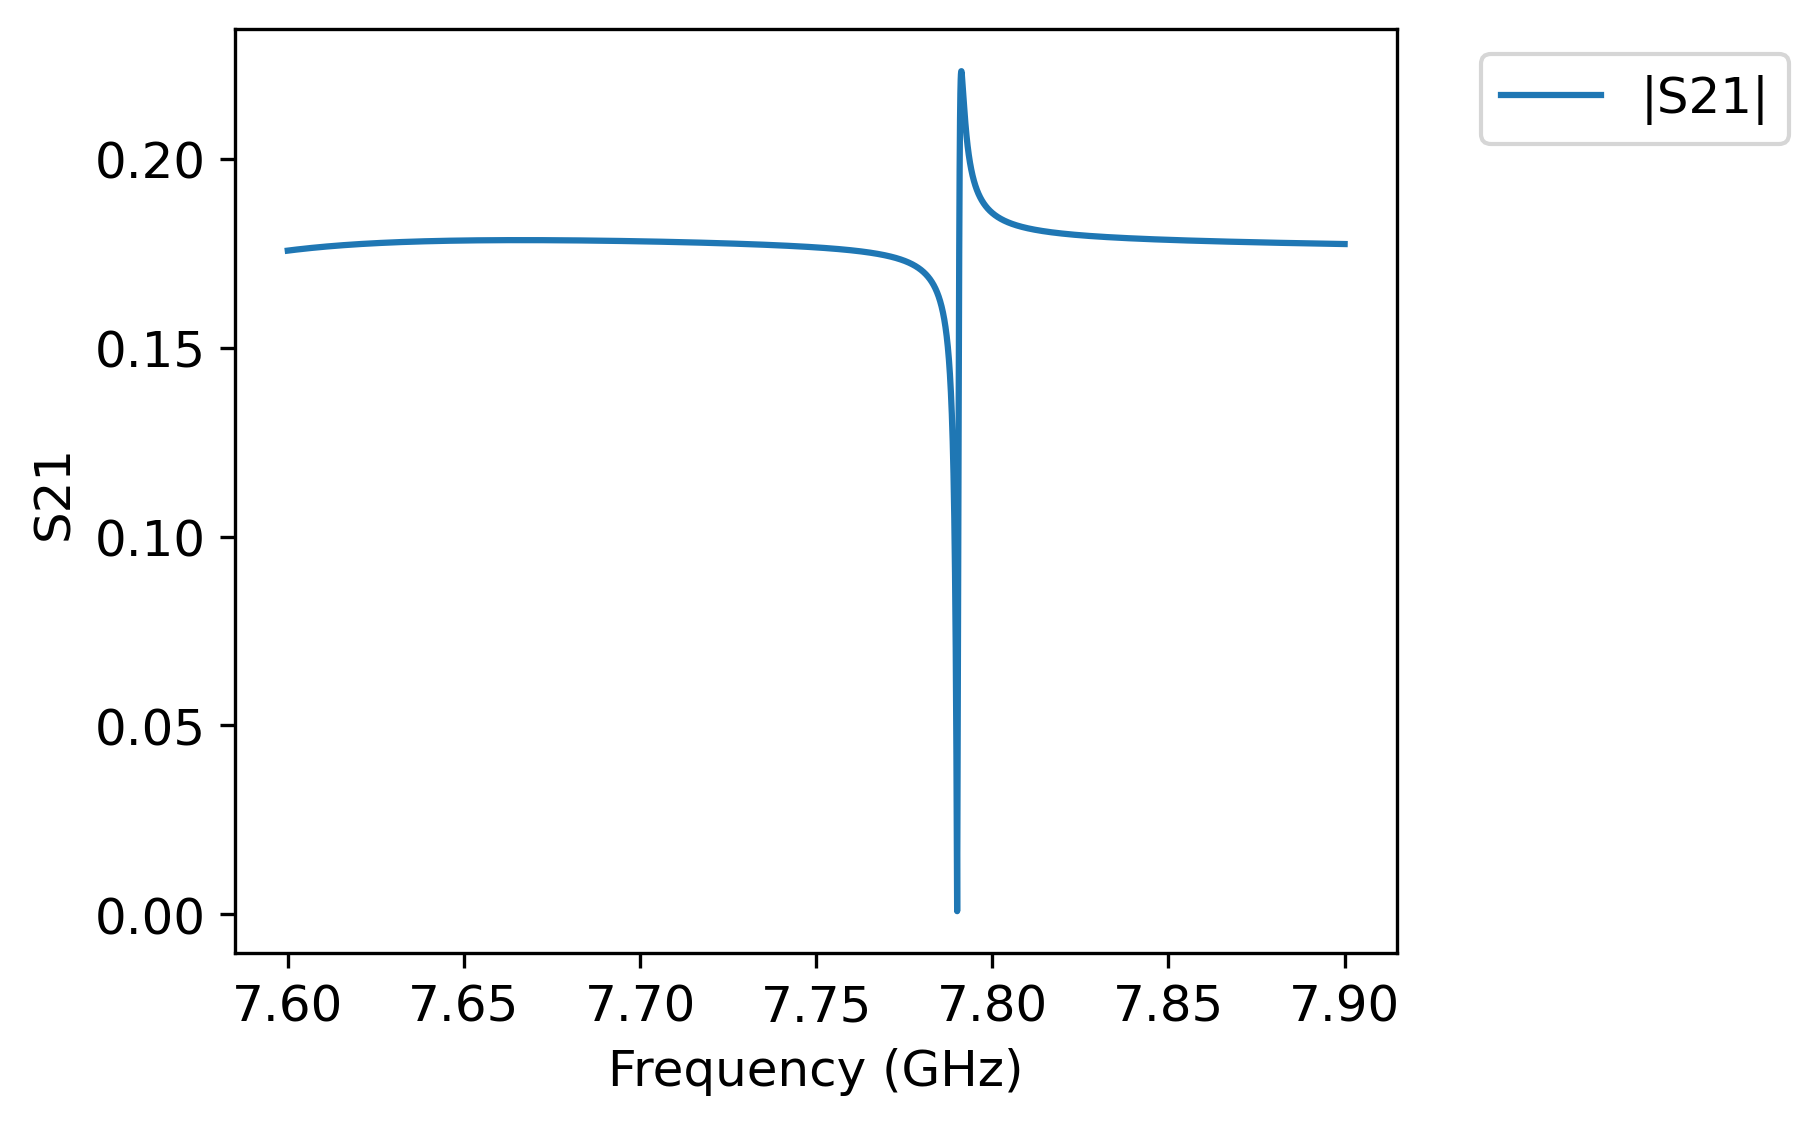

wr = 7.79 GHz
kappa = 1.15 MHz


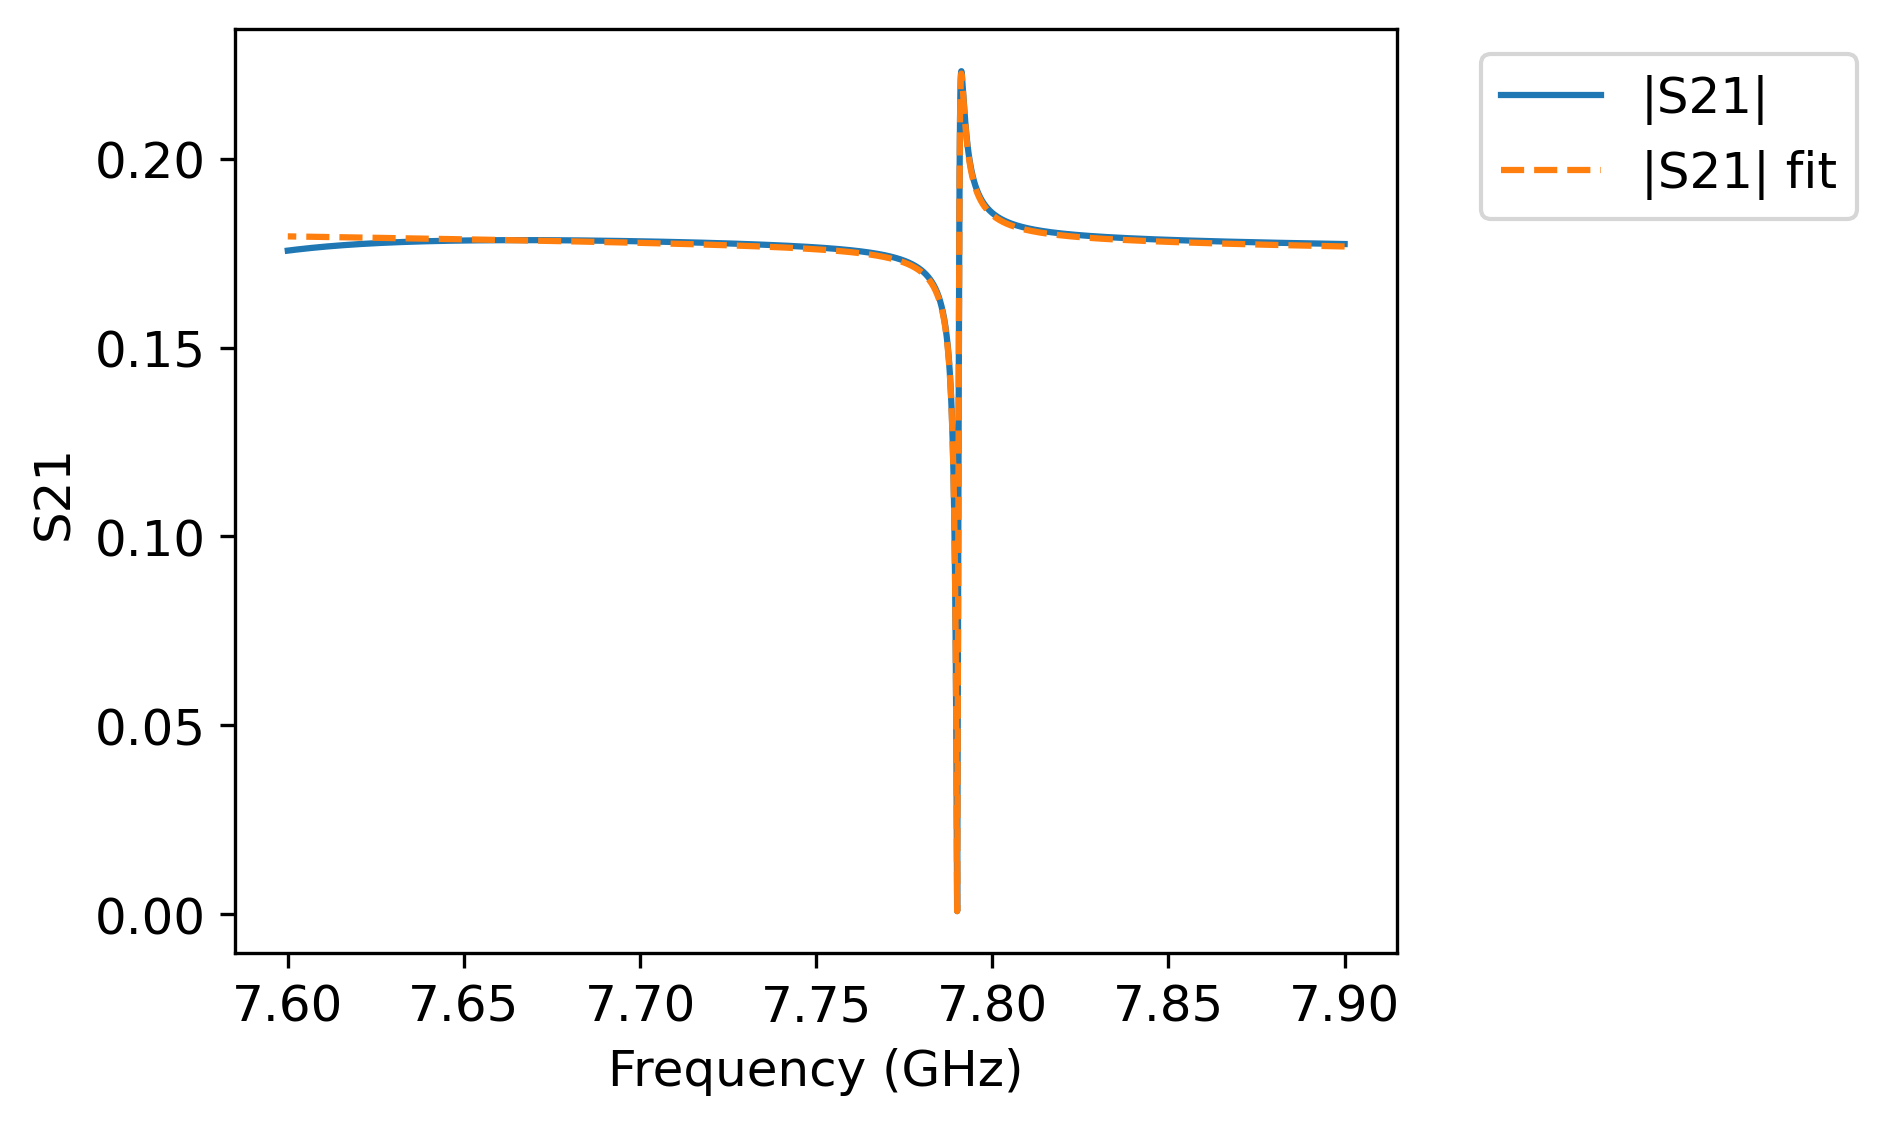

In [147]:
#Q3 resonator fit

w_arr = 2*pi* np.linspace(7.9, 7.6, 30_000) * GHz # frequency array in rad/s
s21 = abcd_readout_line_1.sparams(w_arr, z0)[2]
plot_s21(
    w_arr,
    [(np.abs(s21), '|S21|', '-')]
)

fit_results_dict, s21_fit_trace = fit_resonance(w_arr, s21)
# wr and kr are in rad/s
wr = fit_results_dict['wr'] /2/pi/GHz # in GHz
kappa = fit_results_dict['kr'] /2/pi/MHz # in MHz

print(f'wr = {wr:.2f} GHz')
print(f'kappa = {kappa:.2f} MHz')

plot_s21(
    w_arr,
    [(np.abs(s21), '|S21|', '-'),
    (np.abs(s21_fit_trace), '|S21| fit', '--')]
)

In [17]:
import importlib, utils_2
importlib.reload(utils_2)  # force reload after your edits

# sanity-check: inspect the signature and defaults
import inspect
print(inspect.signature(utils_2.fit_resonance_coupled))
print(utils_2.fit_resonance_coupled.__defaults__)  # should include (False, True)

# now call the module-qualified function
res = utils_2.fit_resonance_coupled(w_arr, s21, return_full=True, verbose=False)


(ws: Optional[numpy.ndarray] = None, s21s: Optional[numpy.ndarray] = None, manual_graph_guess: Optional[dict] = None, return_full: bool = False, verbose: bool = True) -> Union[Tuple[dict, numpy.ndarray], Tuple[lmfit.model.ModelResult, dict, numpy.ndarray]]
(None, None, None, False, True)


wr     = 7.46 GHz ± 0.0041 MHz
kappa_p= 130.50 MHz ± 0.268 MHz
wp     = 7.46 GHz ± 0.0072 MHz
J      = 10.26 MHz ± 0.0116 MHz


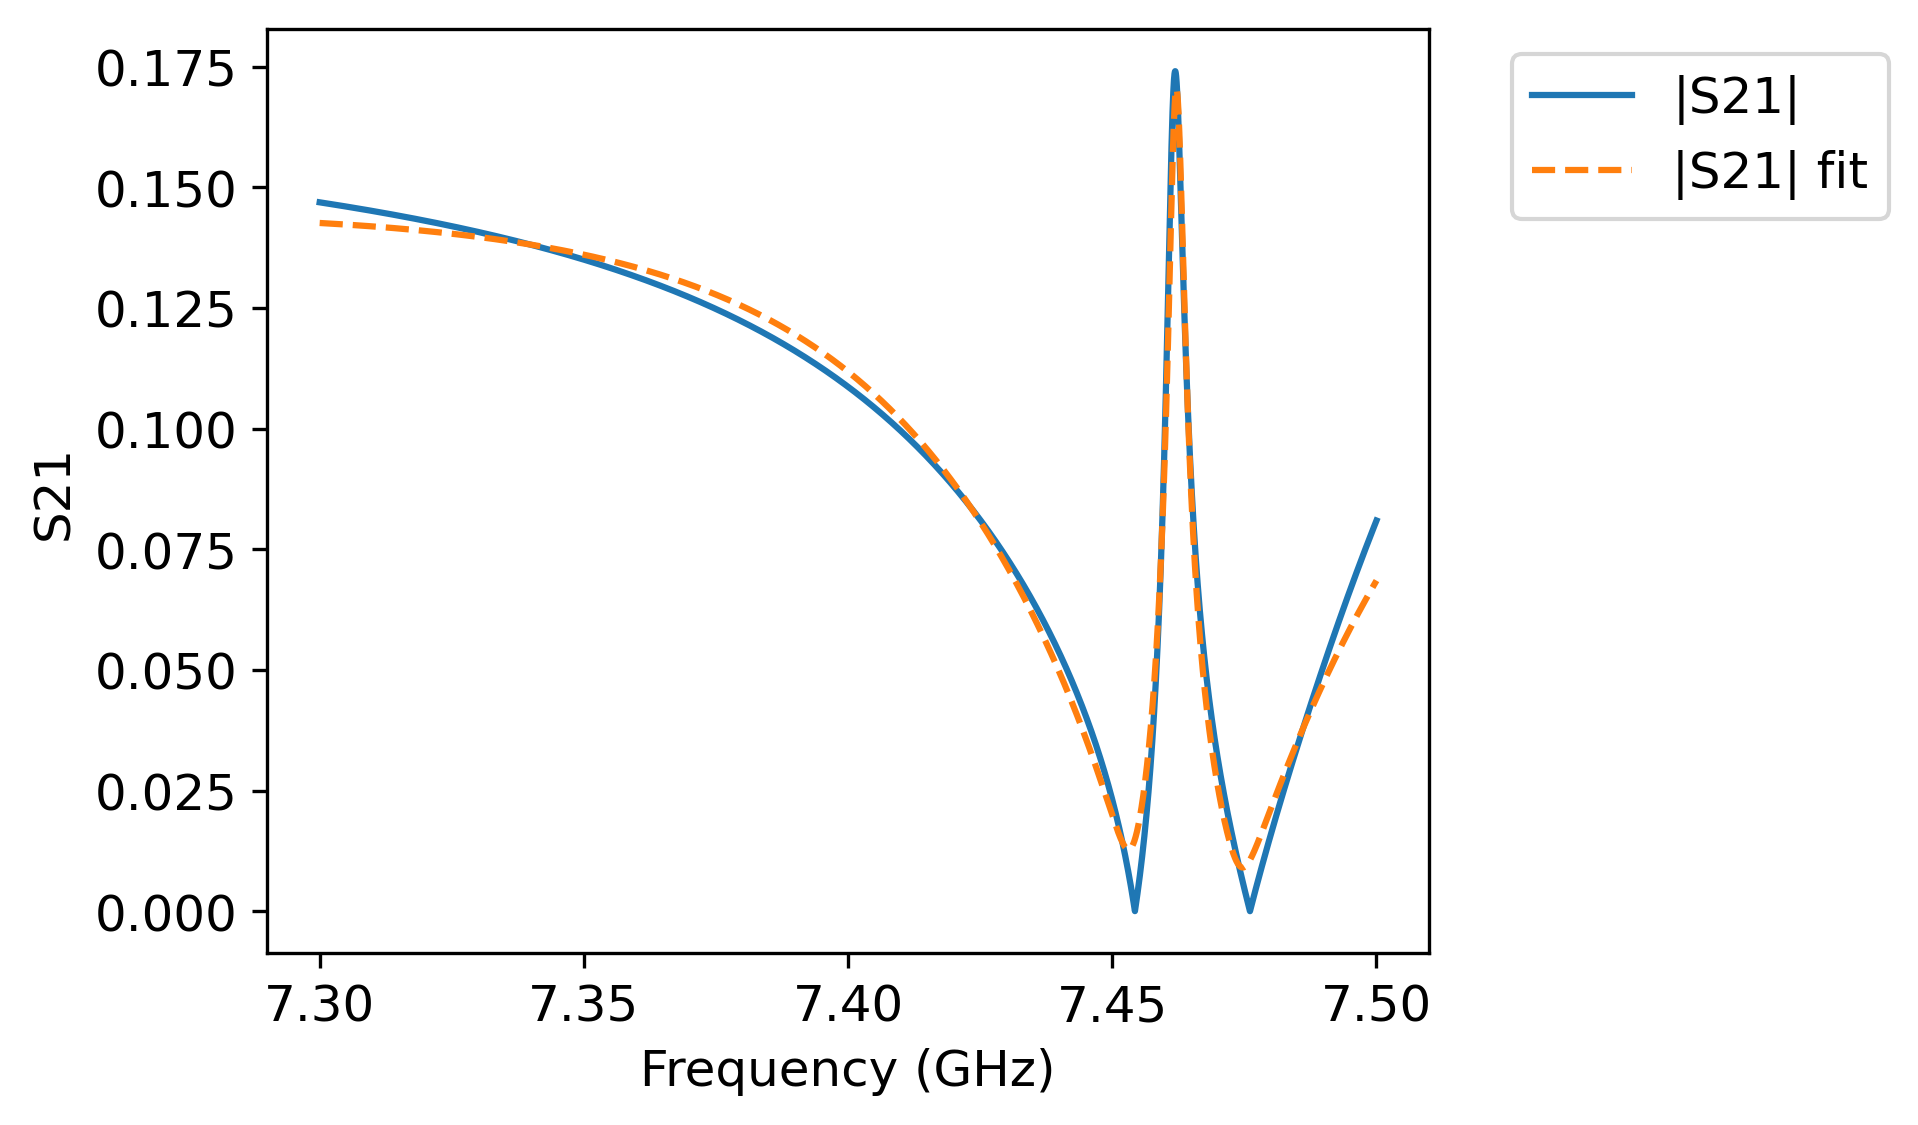

In [149]:

w_arr = 2*pi* np.linspace(7.3, 7.5, 30_000) * GHz # frequency array in rad/s
s21 = abcd_readout_line_1.sparams(w_arr, z0)[2]
# plot_s21(
#     w_arr,
#     [(np.abs(s21), '|S21|', '-')]
# )

# fit_results_dict, s21_fit_trace = utils_2.fit_resonance_coupled(w_arr, s21)

# Do the fit and get both objects
result, fit_dict, s21_fit = utils_2.fit_resonance_coupled(
    w_arr, s21, return_full=True, verbose=False
)

if result is None:
    print("Fit fell back to graphical guess; no lmfit result available.")
else:
    p = result.params
    # helper for safe stderr
    def se(name): 
        return p[name].stderr if p[name].stderr is not None else float('nan')

    # --- VALUES from fit_dict (rad/s) -> print in GHz / MHz like Code 1 ---
    wr_GHz     = fit_dict['omega_r'] / (2*np.pi*GHz)
    wp_GHz     = fit_dict['omega_p'] / (2*np.pi*GHz)
    kappa_MHz  = fit_dict['kappa_p'] / (2*np.pi*MHz)
    J_MHz      = fit_dict['J']       / (2*np.pi*MHz)

    # --- ERRORS from result.params (in GHz) -> convert to your print units ---
    dwr_GHz    = se('omega_r')                # GHz
    dwp_GHz    = se('omega_p')                # GHz
    dkappa_MHz = se('kappa_p') * 1e3          # GHz -> MHz
    dJ_MHz     = se('J') * 1e3                # GHz -> MHz

 # Print like your example, now with ±
    print(f"wr     = {wr_GHz:0.2f} GHz ± {dwr_GHz*1e3:0.4f} MHz")
    print(f"kappa_p= {kappa_MHz:0.2f} MHz ± {dkappa_MHz:0.3f} MHz")
    print(f"wp     = {wp_GHz:0.2f} GHz ± {dwp_GHz*1e3:0.4f} MHz")
    print(f"J      = {J_MHz:0.2f} MHz ± {dJ_MHz:0.4f} MHz")



# # wr and kr are in rad/s
# wr = fit_results_dict['omega_r'] /2/pi/GHz # in GHz
# kappa = fit_results_dict['kappa_p'] /2/pi/MHz # in MHz
# J = fit_results_dict['J'] /2/pi/MHz # in MHz
# wp = fit_results_dict['omega_p'] /2/pi/GHz # in GHz

# print(f'wr = {wr:.2f} GHz')
# print(f'kappa_p = {kappa:.2f} MHz')
# print(f'wp = {wp:.2f} GHz')
# print(f'J = {J:.2f} MHz')

plot_s21(
    w_arr,
    [(np.abs(s21), '|S21|', '-'),
    (np.abs(s21_fit), '|S21| fit', '--')]
)

In [150]:
omega1, omega2, kappa1, kappa2 = mode_split(fit_dict['omega_r'], fit_dict['omega_p'], fit_dict['kappa_p'], fit_dict['J'])
print(f"omega1: {omega1 / 2/ np.pi / GHz:.3f} GHz, omega2: {omega2 / 2/ np.pi / GHz:.3f} GHz")
print(f"kappa1: {kappa1 / 2/ np.pi / MHz:.3f} MHz, kappa2: {kappa2 / 2/ np.pi / MHz:.3f} MHz")

omega1: 7.462 GHz, omega2: 7.463 GHz
kappa1: 127.191 MHz, kappa2: 3.311 MHz


(ws: Optional[numpy.ndarray] = None, s21s: Optional[numpy.ndarray] = None, manual_graph_guess: Optional[dict] = None, return_full: bool = False, verbose: bool = True) -> Union[Tuple[dict, numpy.ndarray], Tuple[lmfit.model.ModelResult, dict, numpy.ndarray]]
(None, None, None, False, True)


In [151]:
# Do the fit and get both objects
result, fit_dict, s21_fit = utils_2.fit_resonance_coupled(
    w_arr, s21, return_full=True, verbose=False
)

if result is None:
    print("Fit fell back to graphical guess; no lmfit result available.")
else:
    p = result.params
    # helper for safe stderr
    def se(name): 
        return p[name].stderr if p[name].stderr is not None else float('nan')

    # --- VALUES from fit_dict (rad/s) -> print in GHz / MHz like Code 1 ---
    wr_GHz     = fit_dict['omega_r'] / (2*np.pi*GHz)
    wp_GHz     = fit_dict['omega_p'] / (2*np.pi*GHz)
    kappa_MHz  = fit_dict['kappa_p'] / (2*np.pi*MHz)
    J_MHz      = fit_dict['J']       / (2*np.pi*MHz)

    # --- ERRORS from result.params (in GHz) -> convert to your print units ---
    dwr_GHz    = se('omega_r')                # GHz
    dwp_GHz    = se('omega_p')                # GHz
    dkappa_MHz = se('kappa_p') * 1e3          # GHz -> MHz
    dJ_MHz     = se('J') * 1e3                # GHz -> MHz

 # Print like your example, now with ±
    print(f"wr     = {wr_GHz:0.2f} GHz ± {dwr_GHz*1e3:0.4f} MHz")
    print(f"kappa_p= {kappa_MHz:0.2f} MHz ± {dkappa_MHz:0.3f} MHz")
    print(f"wp     = {wp_GHz:0.2f} GHz ± {dwp_GHz*1e3:0.4f} MHz")
    print(f"J      = {J_MHz:0.2f} MHz ± {dJ_MHz:0.4f} MHz")


wr     = 7.46 GHz ± 0.0041 MHz
kappa_p= 130.50 MHz ± 0.268 MHz
wp     = 7.46 GHz ± 0.0072 MHz
J      = 10.26 MHz ± 0.0116 MHz


## Make FLuxonium resonators 100 MHz smaller

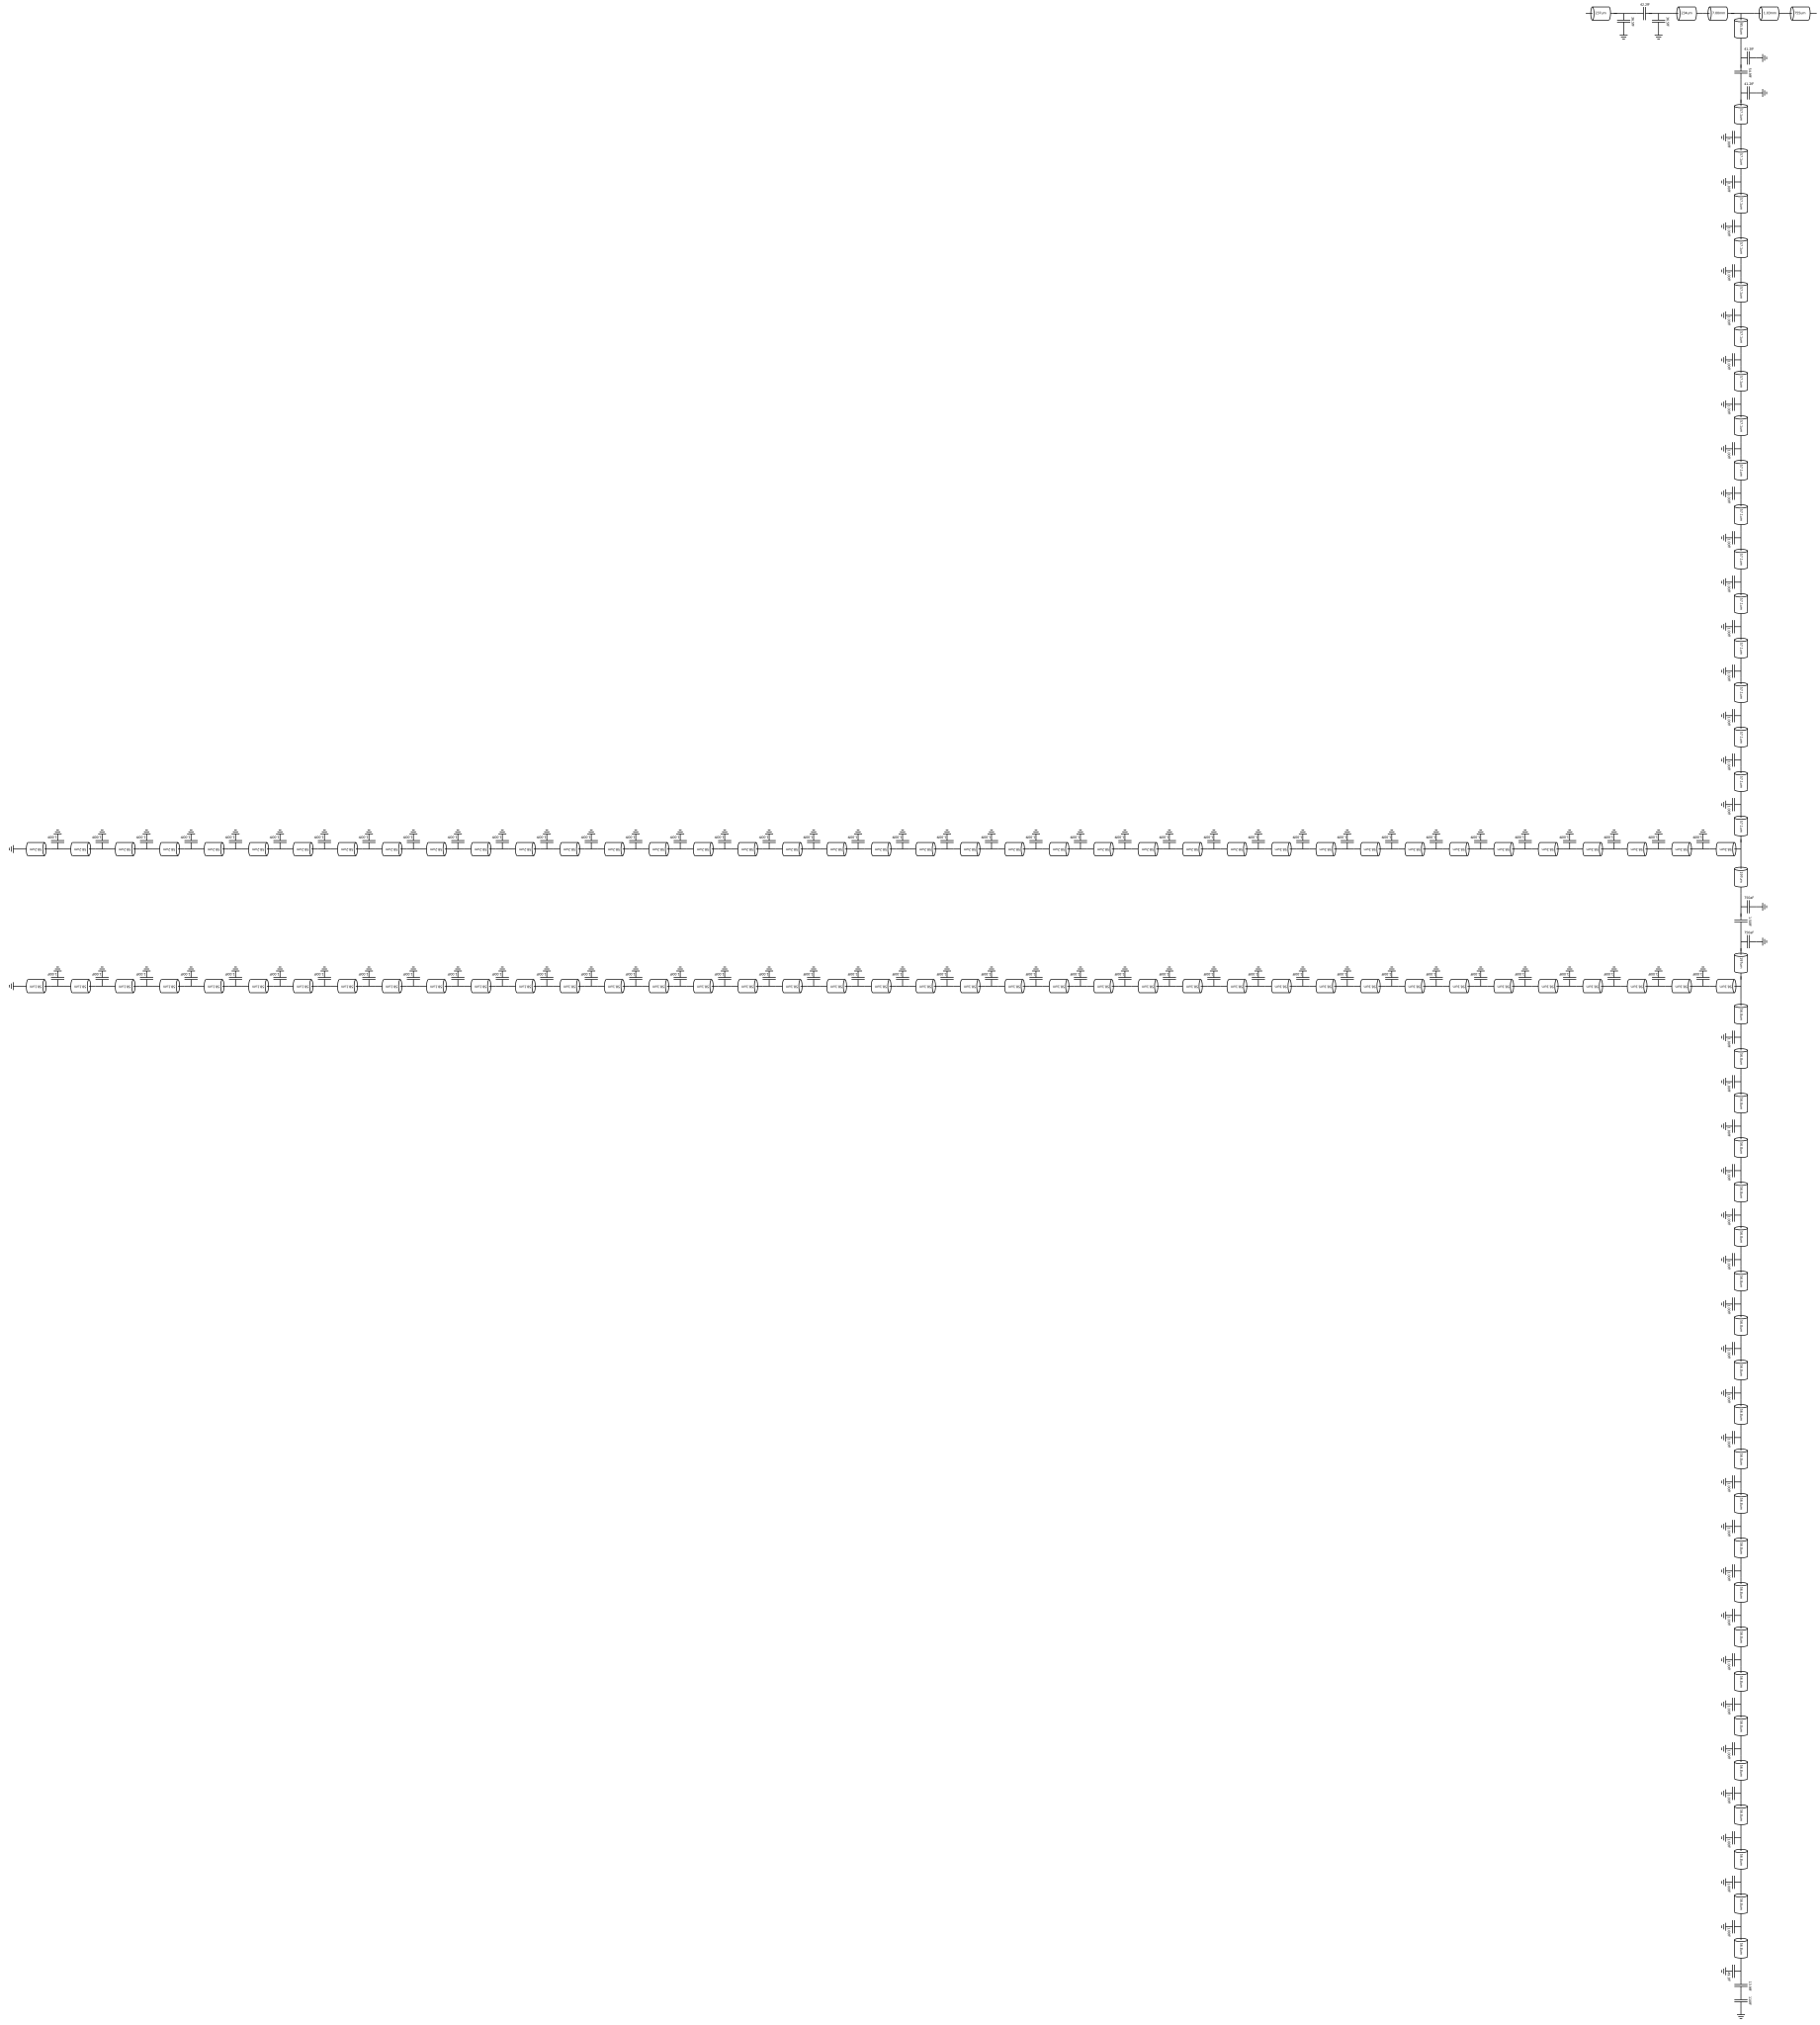

In [182]:
# considering air bridge capacitance of 1fF
# drawing the shapes

lf = 15000*um # length of the feedline

#Start from left
lf_section_1 = 237*um
C_1 = 42.25*fF
C_1_gr = 36.5*fF

#Resonator for Q3
lf_section_2 = 234*um
Cc_Q3 = 11.79*fF #9.8*fF
Cc_Q3_gr = 11.007*fF  # 8.26*fF
lt_section_1 = (160+ 40)*um # consider the length in the coupler part too. total coupler 400um so divided by two. 
lt_section_2 = (160+ 40)*um

lrp_Q3 = (360+2312+25)*um
lr_Q3 = lrp_Q3 + (1060+25)*um

lrp_Q3_1 = 200*um

Cg_Q3 = 10.5*fF





# Reaout of Q2

lf_section_3 = 7000*um
lt_section_4  = 95*um
lt_section_5  = 197*um


C_p_Q2 =54.88*fF
C_p_gr_Q2 = 41.25*fF
lp_Q2= 3238*um
lpr_Q2 = .97*mm

lr_Q2 = 3515*um
lrp_Q2 = (0.27 + .73 + .5/2 )*mm
Cj_Q2 = 1.5*fF
Cj_gr_Q2 = 0.75*fF

Cg_Q2 = 49.1*fF
Cg_rq = 13.92*fF
Cq_gr = 110*fF
lf2 = 1028*um #lf-lf_section_3


#Resonator for Q1
lf_section_2 = 234*um
Cc_Q1 = 9.8*fF
Cc_Q1_gr = 8.26*fF
lt_section_6 = (160+ 40)*um # three fingers equivalent extra length so good approximation!? 
lt_section_7 = (160+ 40)*um

# lrp_Q1 = (370+1840+25)*um
lrp_Q1 = (360+1829+25)*um




lr_Q1 = lrp_Q1 + (1400+25)*um #check when updated this

Cg_Q1 = 10.5*fF
lf3 = 755*um


C_air_bridge = 1*fF
distance_between_air_bridges = 60*um





# w_arr = 2*pi* np.linspace(7.5, 7.7, 20_000) * GHz # frequency array in rad/s


# def add_air_bridge(length, C_air_bridge, number_of_bridges):
#     # Function to add air bridge capacitance at regular intervals
#     #divide the length into ~number_of_bridges segments
#     #segment_length = length // number_of_bridges
#     # return ABCDTEMTransmissionLine(segment_length,z0,vp)* ABCDParallelCapacitance(C_air_bridge)*ABCDTEMTransmissionLine(2*segment_length,z0,vp)
#     # *ABCDParallelCapacitance(C_air_bridge)* ...ABCDTEMTransmissionLine(length - number_of_bridges*segment_length,z0,vp)
#   return 0

abcd_readout_line_1 = (
                            ABCDTEMTransmissionLine(lf_section_1,z0,vp)
                            * ABCDTJunction(ABCDSeriesCapacitance(C_1_gr))
                            * ABCDSeriesCapacitance(C_1)
                            * ABCDTJunction(ABCDSeriesCapacitance(C_1_gr))
                          *ABCDTEMTransmissionLine(lf_section_2,z0,vp)
                          # *ABCDTEMTransmissionLine(lf1,z0,vp)
                        #  * ABCDTJunction(
                        #                   ABCDTEMTransmissionLine(lt_section_1,z0,vp)
                        #                   *ABCDInverse(ABCDTJunction(ABCDSeriesCapacitance(Cc_Q3_gr)))
                        #                    * ABCDSeriesCapacitance(Cc_Q3)
                        #                    *ABCDInverse(ABCDTJunction(ABCDSeriesCapacitance(Cc_Q3_gr)))
                        #                    *ABCDTEMTransmissionLine(lt_section_2,z0,vp)

                                         
                        #                    * ABCDTJunction(
                        #                        add_air_bridge(lr_Q3-lrp_Q3, C_air_bridge, np.round((lr_Q3 - lrp_Q3) / distance_between_air_bridges).astype(int), z0=z0, vp=vp) 
                        #                        ) 
                                           
                        #                   #  * ABCDTEMTransmissionLine(lrp_Q3,z0,vp)
                        #                   * add_air_bridge(lrp_Q3, C_air_bridge, np.round((lrp_Q3)/distance_between_air_bridges).astype(int), z0=z0, vp=vp)

                        #                     * ABCDSeriesCapacitance(Cg_Q3)
                        #                    ) 
                            *ABCDTEMTransmissionLine(lf_section_3,z0,vp)
                          * ABCDTJunction(
                                          ABCDTEMTransmissionLine(lt_section_4,z0,vp)
                                          *ABCDInverse(ABCDTJunction(ABCDSeriesCapacitance(C_p_gr_Q2)))
                                         * ABCDSeriesCapacitance(C_p_Q2) 
                                         * ABCDInverse(ABCDTJunction(ABCDSeriesCapacitance(C_p_gr_Q2)))


                                        #  * ABCDTEMTransmissionLine(lpr_Q2,z0,vp) 
                                         * add_air_bridge(lpr_Q2, C_air_bridge, np.round((lpr_Q2)/distance_between_air_bridges).astype(int), z0=z0, vp=vp)

                                         *  ABCDTJunction(
                                            #  ABCDTEMTransmissionLine(lp_Q2-lpr_Q2,z0,vp)
                                             add_air_bridge(lp_Q2-lpr_Q2, C_air_bridge, np.round((lp_Q2-lpr_Q2)/distance_between_air_bridges).astype(int), z0=z0, vp=vp)

                                                              )
                                         
                                         
                                         * ABCDTEMTransmissionLine(lt_section_5,z0,vp)
                                          *ABCDInverse(ABCDTJunction(ABCDSeriesCapacitance( Cj_gr_Q2)))
                                           * ABCDSeriesCapacitance(Cj_Q2)
                                           *ABCDInverse(ABCDTJunction(ABCDSeriesCapacitance(Cj_gr_Q2)))
                                           * ABCDTEMTransmissionLine(lt_section_5,z0,vp)

                                           * ABCDTJunction(
                                              #  ABCDTEMTransmissionLine(lr_Q2-lrp_Q2,z0,vp)
                                               add_air_bridge(lr_Q2-lrp_Q2, C_air_bridge, np.round((lr_Q2-lrp_Q2)/distance_between_air_bridges).astype(int), z0=z0, vp=vp)
                                               )
                                           
                                          #  * ABCDTEMTransmissionLine(lrp_Q2,z0,vp)
                                          *add_air_bridge(lrp_Q2, C_air_bridge, np.round((lrp_Q2)/distance_between_air_bridges).astype(int), z0=z0, vp=vp)


                                            * ABCDParallelCapacitance(Cg_Q2)


                                            #new adding qubit caps
                                            *ABCDSeriesCapacitance (Cg_rq)
                                            *ABCDSeriesCapacitance (Cq_gr)

                                           ) 
                        *  ABCDTEMTransmissionLine(lf2,z0,vp)
                          # * ABCDTJunction(
                          #                 ABCDTEMTransmissionLine(lt_section_6,z0,vp)
                          #                 *ABCDInverse(ABCDTJunction(ABCDSeriesCapacitance(Cc_Q1_gr)))
                          #                  * ABCDSeriesCapacitance(Cc_Q1)
                          #                  *ABCDInverse(ABCDTJunction(ABCDSeriesCapacitance(Cc_Q1_gr)))
                          #                  *ABCDTEMTransmissionLine(lt_section_7,z0,vp)
                          #                  * ABCDInverse(ABCDTJunction(
                          #                      #  ABCDTEMTransmissionLine(lr_Q1-lrp_Q1,z0,vp)
                          #                      add_air_bridge(lr_Q1-lrp_Q1, C_air_bridge, np.round((lr_Q1-lrp_Q1)/distance_between_air_bridges).astype(int), z0=z0, vp=vp)
                          #                      ))
                                           
                          #                 #  * ABCDTEMTransmissionLine(lrp_Q1,z0,vp)
                          #                 *add_air_bridge(lrp_Q1, C_air_bridge, np.round((lrp_Q1)/distance_between_air_bridges).astype(int), z0=z0, vp=vp)

                                           
                          #                   * ABCDSeriesCapacitance(Cg_Q1)
                          #                  ) 
                           *ABCDTEMTransmissionLine(lf3,z0,vp)
                        
                        
                        
                        
                        
                        
                        
                        )
                          


abcd_readout_line_1

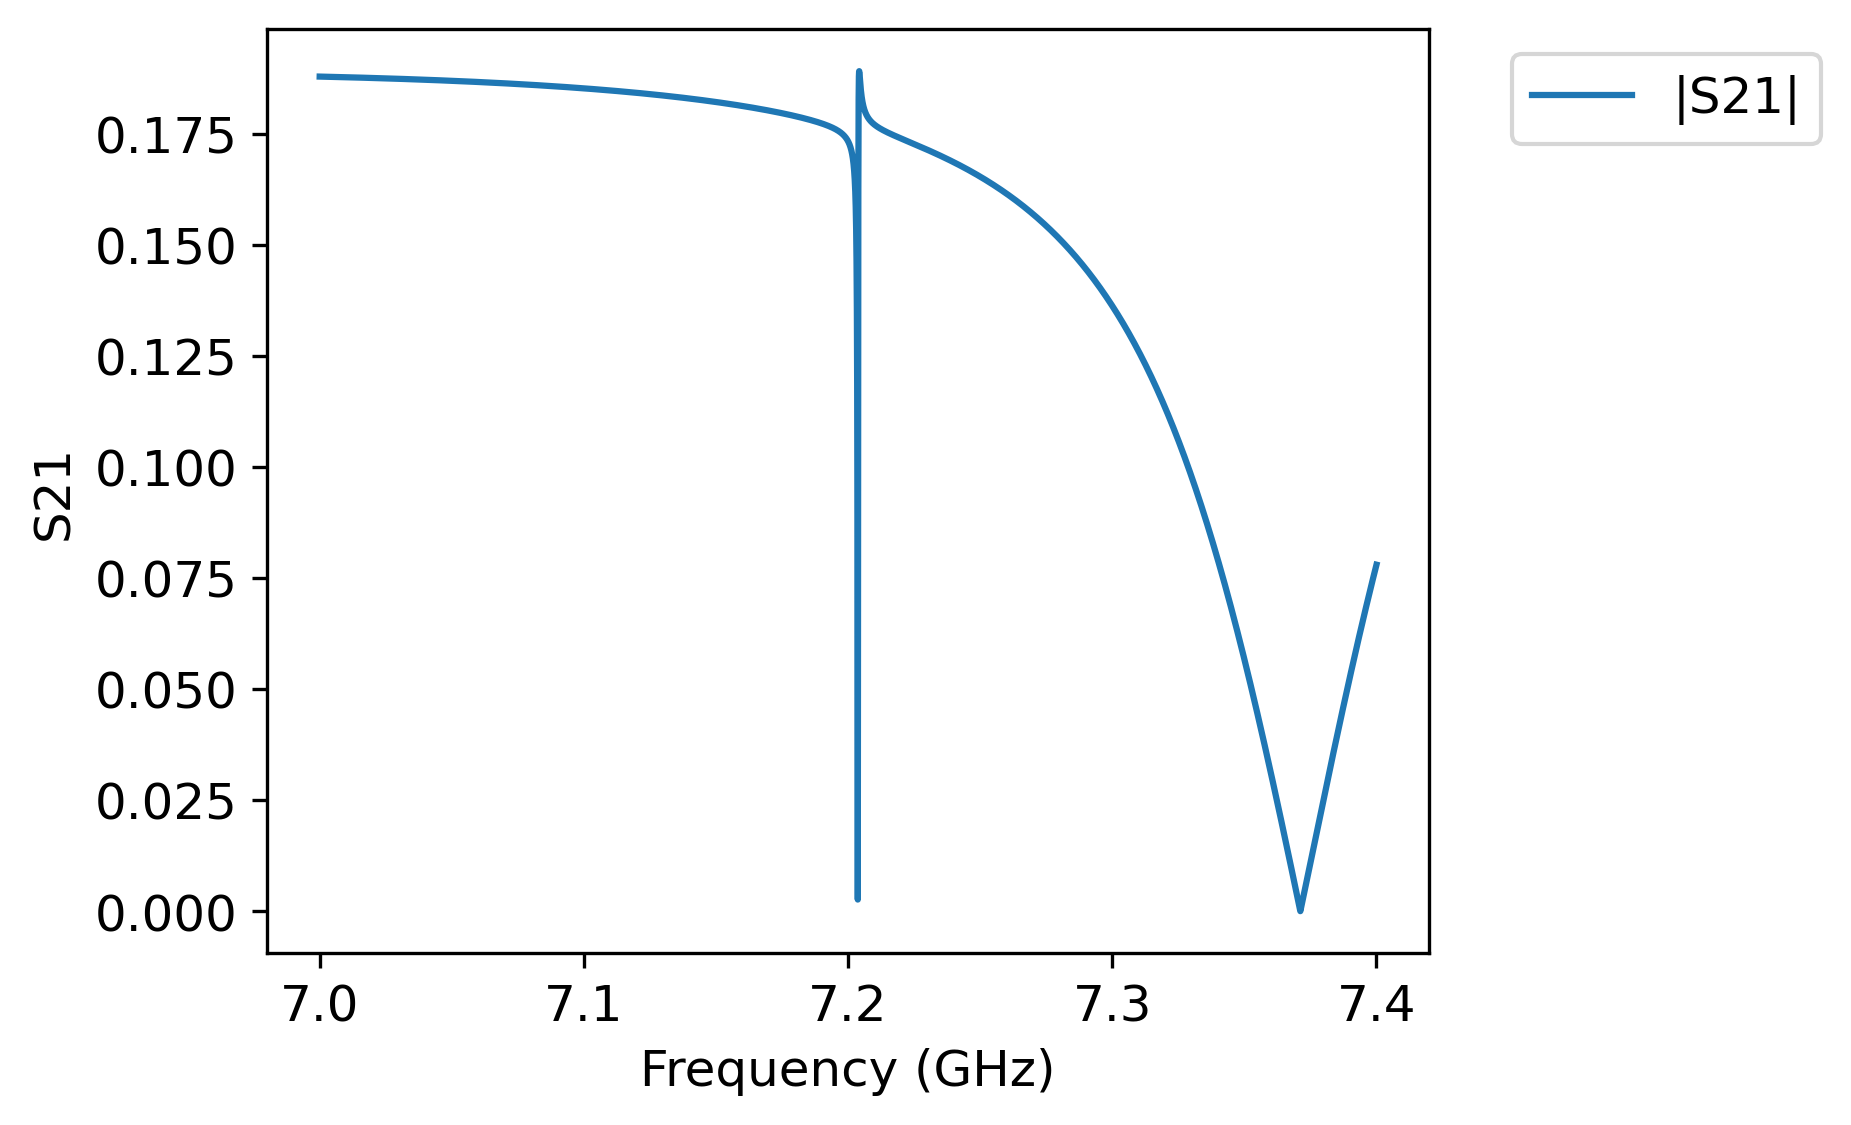

wr = 7.20 GHz
kappa = 0.36 MHz


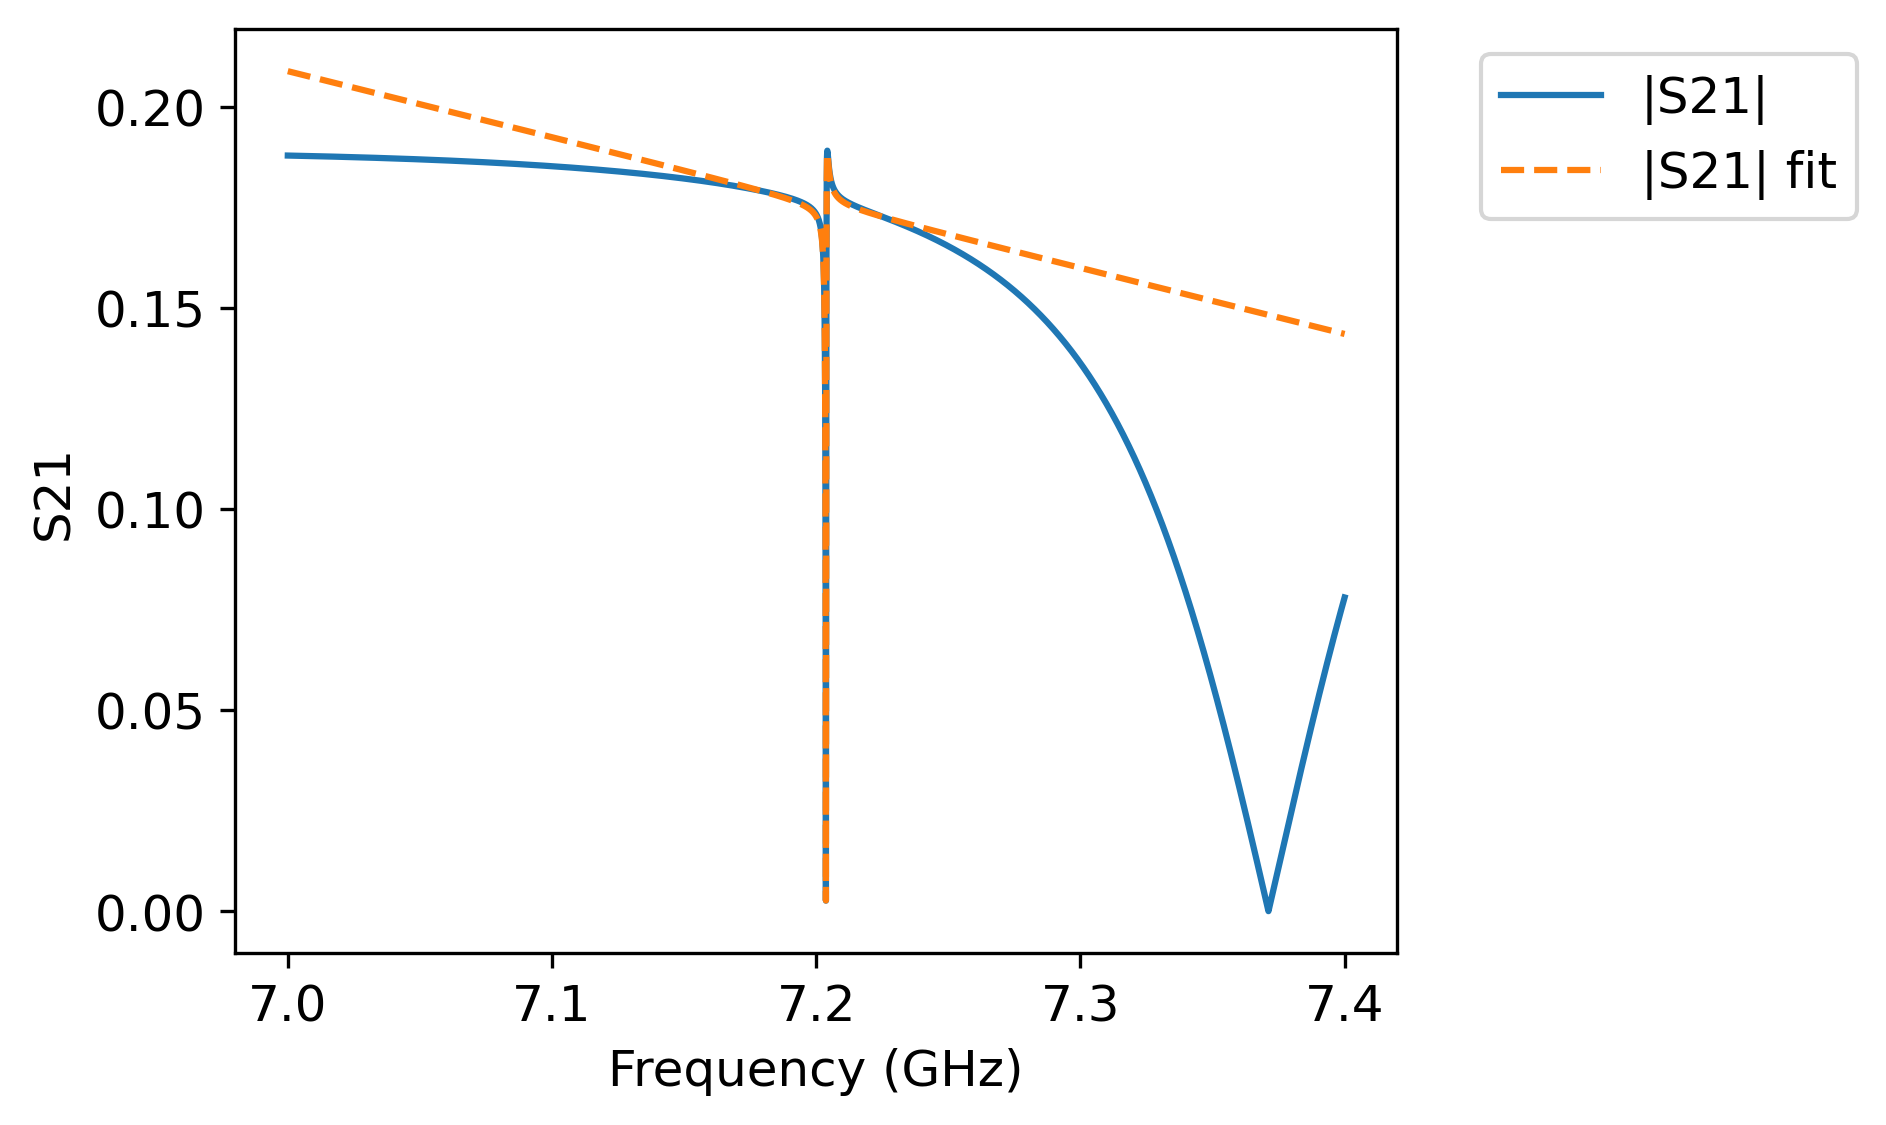

In [183]:
#Q3 resonator fit

w_arr = 2*pi* np.linspace(7, 7.4, 30_000) * GHz # frequency array in rad/s
s21 = abcd_readout_line_1.sparams(w_arr, z0)[2]
plot_s21(
    w_arr,
    [(np.abs(s21), '|S21|', '-')]
)

fit_results_dict, s21_fit_trace = fit_resonance(w_arr, s21)
# wr and kr are in rad/s
wr = fit_results_dict['wr'] /2/pi/GHz # in GHz
kappa = fit_results_dict['kr'] /2/pi/MHz # in MHz

print(f'wr = {wr:.2f} GHz')
print(f'kappa = {kappa:.2f} MHz')

plot_s21(
    w_arr,
    [(np.abs(s21), '|S21|', '-'),
    (np.abs(s21_fit_trace), '|S21| fit', '--')]
)